### Newsbot to write a daily AI news summary using langgraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary
- Used to generate a daily newsletter at skynetandchill.com and potentially an autogenerated podcast

Possible TODOs:
- after writing summaries, could parallelize some stuff, topic analysis, ratings
- could also add tools to check format
- rewrite using an critic-refine flow, although one rewrite does an OK job
- do more evals with promptfoo, promptlayer, do prompt optimization with eg dspy or your own algo
- retrain reducer, identify a good number of dimensions using silhoutee score


In [1]:
# to selectively re-import as needed
import sys
# del sys.modules['ainb_llm']
# del sys.modules['ainb_const']
# del sys.modules['ainb_utilities']
# del sys.modules['ainb_webscrape']
# del sys.modules['AInewsbot_langgraph']



In [2]:
import os
import shutil
# import dotenv
# import subprocess

from collections import Counter
import json
import uuid
import re
# import operator
import pickle
from datetime import datetime, timedelta

import langchain
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic

from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import (ChatPromptTemplate, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser

from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.errors import NodeInterrupt
from langchain.globals import set_debug

import numpy as np
import pandas as pd
import umap

import sklearn

import bs4

from tenacity import (
    retry,
    stop_after_attempt,
    wait_exponential,
    retry_if_exception_type
)

import asyncio
from asyncio import Semaphore

from IPython.display import HTML, Image, Markdown, display

# import pyperclip
# import shlex

import openai
from openai import OpenAI

from pydantic import BaseModel, Field
from typing import List, TypedDict, Annotated, Any

from google.cloud import aiplatform
from vertexai.language_models import TextGenerationModel
import google.generativeai as genai
import httpx

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate

from ainb_prompts import (
                        REWRITE_SYSTEM_PROMPT, REWRITE_USER_PROMPT,
                        SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT
                       )

from ainb_utilities import log

from AInewsbot_langgraph import (Agent, AgentState, initialize_agent,
                                )


import podcastfy
from podcastfy.client import generate_podcast, process_content

from IPython.display import Audio, display, Markdown

import pdb

# need this to run async in jupyter since it already has an asyncio event loop running
import asyncio
import nest_asyncio
nest_asyncio.apply()

# Activate global verbose logging
set_debug(False)


In [3]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")
print(f"podcastfy         {podcastfy.__version__}")


Python            3.11.11 (main, Dec 11 2024, 10:25:04) [Clang 14.0.6 ]
LangChain         0.3.19
OpenAI            1.64.0
trafilatura       2.0.0
numpy             1.26.4
pandas            2.2.3
sklearn           1.6.1
umap              0.5.7
podcastfy         0.4.1


# Instantiate agent and run LangGraph workflow graph end to end

In [ ]:
# before_date = None
before_date = '2025-05-01 08:00'
do_download = False

# low, medium, high models
ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1-mini', 'o4-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'

lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=8)
log(f"thread_id: {thread_id}")

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": thread_id}}
state = lg_agent.run(lg_state, config)


In [ ]:
# it will stop if verify sources not passed
# or if we force a stop compiling with e.g. interrupt_before=["filter_urls"]
# if something got a robot block, download manually and rerun from beginning

last_state = lg_agent.graph.get_state(config).values
sources_downloaded = len(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(last_state["sources"].keys()) - set(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']].index )


In [ ]:
last_state = lg_agent.graph.get_state(config)
aidf = pd.DataFrame(last_state.values["AIdf"])
aidf


In [ ]:
aidf[['url', 'src', 'site_name', 'hostname', 'title', 'actual_url', 'bullet', 'rating']]


In [ ]:
last_state = lg_agent.graph.get_state(config)
last_state.values["do_download"]


In [ ]:
lg_agent.graph.update_state (
    last_state.config,
    {"do_download": False})


In [ ]:
# continue, state=None proceeds from last state
# state = lg_agent.run(None, config)

# this should restart from beginning but doesn't restart browsers if already initialized
state = lg_agent.invoke("initialize", {}, config=last_state.config)


In [ ]:
events = lg_agent.graph.stream(
    last_state,
    last_state.config,
    stream_mode="values"
)

In [ ]:
for e in events:
    pass


In [ ]:
# it will stop again here if we compiled with interrupt_before=["filter_urls", "compose_summary",]
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# print(last_state.values["topics_str"])

# update cluster_topics if desired
# lg_agent.graph.update_state (
#     last_state.config,
#     {
#         "topics_str": """
# African Healthcare & Agriculture
# Anthropic & Palantir Defense Partnership
# Apple iOS 18.2 Updates
# China AI Chips
# China Talent Race
# Construction Industry Transformations
# Credit Innovation at FinTech Festival
# Doubao AI Video Generator
# Google Gemini iOS Launch
# Grok AI Free Plan
# Grok API
# Healthcare Applications
# Hollywood's 'Heretic' AI Movie
# Humanoid Robot Artwork Sale
# Moore Threads Sanction IPO
# NHS Doctor Assistant
# Net Zero Emissions Target
# Passenger Plane Flight Smoother
# Restored Historical Photos
# Scientific Data Fabrication
# Sydney Opera House Image Hoax
# TSMC Chip Exports Halted
# UK Immigration Decision Tool
# """
#     },
#     as_node='propose_topics')

# show updated state
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# last_state.values["topics_str"]

# resume running the graph
# state = lg_agent.run(None, config)


In [ ]:
# finished, show output
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))


# Run each step individually

2025-05-01 20:26:54,202 - AInewsbot - INFO - Initializing with before_date=2025-04-30 18:00, do_download=False, thread_id=f8c71a8b8304405698c09720cdb2a52c


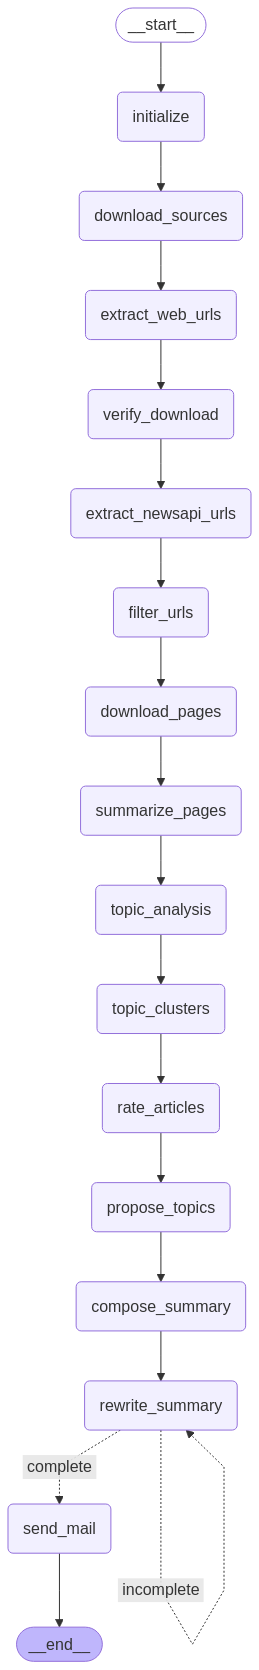

In [4]:
# same as above but w/o using native langgraph runner, run state updates sequentially
# langgraph runner does other stuff implicitly like checkpoint state in sqlite

before_date = None
before_date = '2025-05-01 08:00'
do_download = False

ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1', 'o4-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'
lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=8)

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


In [5]:
lg_state = lg_agent.initialize_config(lg_state)


2025-05-01 20:26:55,306 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2025-05-01 20:26:55,307 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ai/ -> Ars_Technica.html
2025-05-01 20:26:55,309 - AInewsbot - INFO - Bloomberg -> https://www.bloomberg.com/ai -> Bloomberg.html
2025-05-01 20:26:55,310 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business_Insider.html
2025-05-01 20:26:55,310 - AInewsbot - INFO - FT -> https://www.ft.com/technology -> FT.html
2025-05-01 20:26:55,311 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly_AI.html
2025-05-01 20:26:55,311 - AInewsbot - INFO - Hacker News 1 -> https://news.ycom

In [6]:
lg_state = lg_agent.download_sources(lg_state)


2025-05-01 20:26:55,998 - AInewsbot - INFO - Web fetch disabled, using existing files in htmldata
2025-05-01 20:26:56,001 - AInewsbot - INFO - Found 16 previously downloaded files
2025-05-01 20:26:56,003 - AInewsbot - INFO - htmldata/Techmeme.html
2025-05-01 20:26:56,004 - AInewsbot - INFO - htmldata/Hacker_News_1.html
2025-05-01 20:26:56,004 - AInewsbot - INFO - htmldata/Reddit.html
2025-05-01 20:26:56,004 - AInewsbot - INFO - htmldata/HackerNoon.html
2025-05-01 20:26:56,005 - AInewsbot - INFO - htmldata/VentureBeat.html
2025-05-01 20:26:56,005 - AInewsbot - INFO - htmldata/Feedly_AI.html
2025-05-01 20:26:56,006 - AInewsbot - INFO - htmldata/The_Register.html
2025-05-01 20:26:56,006 - AInewsbot - INFO - htmldata/FT.html
2025-05-01 20:26:56,006 - AInewsbot - INFO - htmldata/Business_Insider.html
2025-05-01 20:26:56,007 - AInewsbot - INFO - htmldata/Washington_Post.html
2025-05-01 20:26:56,007 - AInewsbot - INFO - htmldata/New_York_Times.html
2025-05-01 20:26:56,008 - AInewsbot - INFO -

In [7]:
lg_state = lg_agent.extract_web_urls(lg_state)


2025-05-01 20:26:56,530 - AInewsbot - INFO - Parsing html files
2025-05-01 20:26:56,532 - AInewsbot - INFO - Ars Technica -> htmldata/Ars_Technica.html
2025-05-01 20:26:56,581 - AInewsbot - INFO - parse_file - found 169 raw links
2025-05-01 20:26:56,584 - AInewsbot - INFO - parse_file - found 37 filtered links
2025-05-01 20:26:56,584 - AInewsbot - INFO - 37 links found
2025-05-01 20:26:56,584 - AInewsbot - INFO - Bloomberg -> htmldata/Bloomberg.html
2025-05-01 20:26:56,862 - AInewsbot - INFO - parse_file - found 246 raw links
2025-05-01 20:26:56,865 - AInewsbot - INFO - parse_file - found 37 filtered links
2025-05-01 20:26:56,865 - AInewsbot - INFO - 37 links found
2025-05-01 20:26:56,865 - AInewsbot - INFO - Business Insider -> htmldata/Business_Insider.html
2025-05-01 20:26:56,885 - AInewsbot - INFO - parse_file - found 211 raw links
2025-05-01 20:26:56,888 - AInewsbot - INFO - parse_file - found 21 filtered links
2025-05-01 20:26:56,888 - AInewsbot - INFO - 21 links found
2025-05-01

In [8]:
# s/b 16 check all sources downloaded, if any got hit by a bot block then download manually

sources_downloaded = len(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(lg_state["sources"].keys()) - set(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']].index )


number of sources in AIdf 16


,id
src,
Ars Technica,37
Bloomberg,31
Business Insider,21
FT,62
Feedly AI,33
Hacker News 1,28
Hacker News 2,22
HackerNoon,18
New York Times,19


number of missing sources 0


set()

In [9]:
lg_state = lg_agent.verify_download(lg_state)


2025-05-01 20:26:58,072 - AInewsbot - INFO - verify_download passed, found 16 sources in AIdf, 0 missing


In [10]:
lg_state = lg_agent.extract_newsapi_urls(lg_state)


2025-05-01 20:27:00,983 - AInewsbot - INFO - Fetching top 100 stories matching artificial intelligence since 2025-04-30T20:27:00 from NewsAPI


In [11]:
# filter by headlines that we haven't seen and that look like AI
# we don't want to summarize all before filtering on headline
lg_state = lg_agent.filter_urls(lg_state)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])


2025-05-01 20:27:01,831 - AInewsbot - INFO - Querying SQLite with where_clause: WHERE timestamp < '2025-04-30 18:00'
2025-05-01 20:27:02,446 - AInewsbot - INFO - URLs in orig_df: 895
2025-05-01 20:27:02,449 - AInewsbot - INFO - Existing URLs in DB: 252655
2025-05-01 20:27:02,510 - AInewsbot - INFO - New URLs in df filtered by URL: 448
2025-05-01 20:27:02,635 - AInewsbot - INFO - Existing src+title: 30
2025-05-01 20:27:02,635 - AInewsbot - INFO - New URLs in df filtered by src+title: 418
2025-05-01 20:27:02,650 - AInewsbot - INFO - Found 417 unique new headlines
2025-05-01 20:27:02,652 - AInewsbot - INFO - Found 407 unique cleaned new headlines
2025-05-01 20:27:04,422 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:27:09,336 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:27:09,345 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HT

,id
src,
Ars Technica,4
Bloomberg,11
Business Insider,5
FT,8
Feedly AI,22
Hacker News 1,6
Hacker News 2,3
HackerNoon,2
New York Times,2


In [12]:
lg_state = lg_agent.download_pages(lg_state)


2025-05-01 20:27:10,456 - AInewsbot - INFO - Queuing URLs for scraping
2025-05-01 20:27:10,460 - AInewsbot - INFO - Saving HTML files using async concurrency= 8
2025-05-01 20:27:10,782 - AInewsbot - INFO - Launching browser
2025-05-01 20:27:11,834 - AInewsbot - INFO - Launching workers
2025-05-01 20:27:11,835 - AInewsbot - INFO - Launching worker
2025-05-01 20:27:11,835 - AInewsbot - INFO - from queue: 0, https://decrypt.co/317146/natasha-lyonne-direct-star-ai-film, 'AI Can Enable Bigger Visions': Natasha Lyonne to Direct and Star in AI-Powered Film
2025-05-01 20:27:11,836 - AInewsbot - INFO - fetch_url(https://decrypt.co/317146/natasha-lyonne-direct-star-ai-film)
2025-05-01 20:27:11,836 - AInewsbot - INFO - File already exists: htmlpages/AI_Can_Enable_Bigger_Visions___Natasha_Lyonne_to_Direct_and_Star_in_AI-Powered_Film.html
2025-05-01 20:27:11,836 - AInewsbot - INFO - from queue: 1, https://techcrunch.com/2025/04/30/study-accuses-lm-arena-of-helping-top-ai-labs-game-its-benchmark/, A

2025-05-01 20:27:11,862 - AInewsbot - INFO - fetch_url(https://venturebeat.com/ai/addressing-the-developer-skills-gap-the-role-of-ai-in-efficiency-and-skilling/)
2025-05-01 20:27:11,862 - AInewsbot - INFO - File already exists: htmlpages/Addressing_the_developer_skills_gap__the_role_of_AI_in_efficiency_and_skilling.html
2025-05-01 20:27:11,862 - AInewsbot - INFO - from queue: 15, https://venturebeat.com/ai/qwen-swings-for-a-double-with-2-5-omni-3b-model-that-runs-on-consumer-pcs-laptops/, Alibaba releases Qwen2.5-Omni-3B, a scaled-down 3B-parameter variant of its flagship 7B-parameter multimodal model, designed to run on consumer PCs and laptops
2025-05-01 20:27:11,862 - AInewsbot - INFO - fetch_url(https://venturebeat.com/ai/qwen-swings-for-a-double-with-2-5-omni-3b-model-that-runs-on-consumer-pcs-laptops/)
2025-05-01 20:27:11,914 - AInewsbot - INFO - Launching worker
2025-05-01 20:27:11,914 - AInewsbot - INFO - from queue: 16, https://www.bloomberg.com/news/articles/2025-05-01/altman

2025-05-01 20:27:11,962 - AInewsbot - INFO - from queue: 31, https://spacenews.com/defense-focused-space-startup-true-anomaly-raises-260-million/, Colorado-based True Anomaly, which designs hardware and software for military and intelligence space reconnaissance, raised a $260M Series C led by Accel
2025-05-01 20:27:11,962 - AInewsbot - INFO - fetch_url(https://spacenews.com/defense-focused-space-startup-true-anomaly-raises-260-million/)
2025-05-01 20:27:11,963 - AInewsbot - INFO - File already exists: htmlpages/Colorado-based_True_Anomaly__which_designs_hardware_and_software_for_military_and_intelligence_space_reconnaissance__raised_a__260M_Series_C_led_by_Accel.html
2025-05-01 20:27:11,963 - AInewsbot - INFO - from queue: 32, https://abcnews.go.com/Technology/wireStory/conservative-activist-robby-starbuck-sues-meta-ai-responses-121334771, Conservative activist Robby Starbuck sues Meta over AI responses about him
2025-05-01 20:27:11,963 - AInewsbot - INFO - fetch_url(https://abcnews.g

2025-05-01 20:27:32,346 - AInewsbot - INFO - from queue: 44, https://www.businessinsider.com/iot-technology-precision-agriculture-transforming-farming-2025-5, Farmers are using IoT to take the guesswork out of growing
2025-05-01 20:27:32,346 - AInewsbot - INFO - fetch_url(https://www.businessinsider.com/iot-technology-precision-agriculture-transforming-farming-2025-5)
2025-05-01 20:27:50,398 - AInewsbot - INFO - Saving HTML to htmlpages/Farmers_are_using_IoT_to_take_the_guesswork_out_of_growing.html
2025-05-01 20:27:50,419 - AInewsbot - INFO - from queue: 45, https://www.pcgamer.com/gaming-industry/foundry-vtt-creator-does-what-hasbro-wont-with-d-and-d-trashes-the-idea-of-ai-in-tabletop-roleplaying-game-industry-as-a-betrayal/, Foundry VTT creator does what Hasbro won't with D&D, trashes the idea of AI in tabletop roleplaying game industry as a 'betrayal'
2025-05-01 20:27:50,419 - AInewsbot - INFO - fetch_url(https://www.pcgamer.com/gaming-industry/foundry-vtt-creator-does-what-hasbro-

2025-05-01 20:28:02,862 - AInewsbot - INFO - Skipping fetch for 58 https://www.bloomberg.com/news/articles/2025-04-30/grindr-pivots-to-anthropic-amazon-to-power-ai-wingman-feature Grindr Pivots to Anthropic, Amazon to Power AI Wingman Feature
2025-05-01 20:28:02,864 - AInewsbot - INFO - from queue: 59, https://techcrunch.com/2025/04/30/gruve-ai-promises-software-like-margins-for-ai-tech-consulting-disrupting-decades-old-industry/, Gruve.ai, which aims to change the traditional IT consultancy model by using AI agents to improve enterprise margins, raised a $20M Series A led by Mayfield
2025-05-01 20:28:02,865 - AInewsbot - INFO - fetch_url(https://techcrunch.com/2025/04/30/gruve-ai-promises-software-like-margins-for-ai-tech-consulting-disrupting-decades-old-industry/)
2025-05-01 20:28:11,914 - AInewsbot - INFO - Saving HTML to htmlpages/Galaxy_Tab_S11_Series_Will_Have_Heavy_AI_Integration__Samsung_Confirms.html
2025-05-01 20:28:12,040 - AInewsbot - INFO - from queue: 60, https://www.bus

2025-05-01 20:28:27,982 - AInewsbot - INFO - fetch_url(https://t.co/N7e8VYTlni)
2025-05-01 20:28:32,100 - AInewsbot - INFO - Saving HTML to htmlpages/Its_Time_to_Stop_the_100x_Image_Generation_Trend.html
2025-05-01 20:28:32,122 - AInewsbot - INFO - from queue: 73, https://www.wesh.com/article/kids-teens-under-18-shouldnt-use-ai-apps/64630420, Kids and teens under 18 shouldn't use AI companion apps, safety group says
2025-05-01 20:28:32,124 - AInewsbot - INFO - fetch_url(https://www.wesh.com/article/kids-teens-under-18-shouldnt-use-ai-apps/64630420)
2025-05-01 20:28:33,183 - AInewsbot - INFO - Waiting 47.99175758891228 seconds to rate limit techcrunch.com 0.013728833000641316
2025-05-01 20:28:39,402 - AInewsbot - INFO - Saving HTML to htmlpages/Jensen_Huang_said_the_US_and_China_are__very__very_close__in_the_chip_race.html
2025-05-01 20:28:39,490 - AInewsbot - INFO - from queue: 74, https://techcrunch.com/2025/04/30/ai-sales-tax-startup-kintsugi-had-doubled-its-valuation-in-6-months/, K

2025-05-01 20:29:09,979 - AInewsbot - INFO - fetch_url(https://www.theverge.com/news/658602/meta-ray-ban-privacy-policy-ai-training-voice-recordings)
2025-05-01 20:29:13,767 - AInewsbot - INFO - Saving HTML to htmlpages/Meta_increases_its_2025_capex_to_a_range_of__64B_to__72B_due_in_part_to_higher_infrastructure_costs__up_from_its_prior_outlook_of__60B_to__65B__META_jumps_5.html
2025-05-01 20:29:13,794 - AInewsbot - INFO - Saving HTML to htmlpages/Meta_Leans_Into_AI_and_Subscriptions_to_Future-Proof_Its_Ecosystem.html
2025-05-01 20:29:13,819 - AInewsbot - INFO - from queue: 88, https://www.channelnewsasia.com/business/meta-microsoft-reports-lift-ai-related-stocks-5101186, Meta, Microsoft reports lift AI-related stocks
2025-05-01 20:29:13,820 - AInewsbot - INFO - fetch_url(https://www.channelnewsasia.com/business/meta-microsoft-reports-lift-ai-related-stocks-5101186)
2025-05-01 20:29:13,821 - AInewsbot - INFO - File already exists: htmlpages/Meta__Microsoft_reports_lift_AI-related_stock

2025-05-01 20:29:51,045 - AInewsbot - INFO - from queue: 101, https://waymo.com/blog/2025/05/waymo-making-streets-safer-for-vru, New Study: Waymo is reducing serious crashes and making streets safer
2025-05-01 20:29:51,046 - AInewsbot - INFO - fetch_url(https://waymo.com/blog/2025/05/waymo-making-streets-safer-for-vru)
2025-05-01 20:29:51,047 - AInewsbot - INFO - File already exists: htmlpages/New_Study__Waymo_is_reducing_serious_crashes_and_making_streets_safer.html
2025-05-01 20:29:51,048 - AInewsbot - INFO - from queue: 102, https://arstechnica.com/ai/2025/05/researchers-claim-lm-arenas-ai-leaderboard-is-biased-against-open-models/, New study accuses LM Arena of gaming its popular AI benchmark
2025-05-01 20:29:51,048 - AInewsbot - INFO - fetch_url(https://arstechnica.com/ai/2025/05/researchers-claim-lm-arenas-ai-leaderboard-is-biased-against-open-models/)
2025-05-01 20:29:51,051 - AInewsbot - INFO - File already exists: htmlpages/New_study_accuses_LM_Arena_of_gaming_its_popular_AI_b

2025-05-01 20:30:17,977 - AInewsbot - INFO - fetch_url(https://www.theverge.com/news/658850/openai-chatgpt-gpt-4o-update-sycophantic)
2025-05-01 20:30:22,477 - AInewsbot - INFO - Saving HTML to htmlpages/Nvidias_new_tool_can_turn_3D_scenes_into_AI_images.html
2025-05-01 20:30:22,506 - AInewsbot - INFO - from queue: 116, https://codeactsineducation.wordpress.com/2025/04/30/performing-ai-literacy/, Performing AI literacy
2025-05-01 20:30:22,506 - AInewsbot - INFO - fetch_url(https://codeactsineducation.wordpress.com/2025/04/30/performing-ai-literacy/)
2025-05-01 20:30:22,507 - AInewsbot - INFO - File already exists: htmlpages/Performing_AI_literacy.html
2025-05-01 20:30:22,508 - AInewsbot - INFO - from queue: 117, https://www.theverge.com/news/659485/pinterest-ai-image-label-filter-features, Pinterest rolls out an AI modified label globally to indicate AI-generated or AI-edited images, identified via metadata analysis and its own AI classifiers
2025-05-01 20:30:22,508 - AInewsbot - INFO 

2025-05-01 20:30:53,498 - AInewsbot - INFO - File already exists: htmlpages/Salesforce_takes_aim_at_jagged_intelligence_in_push_for_more_reliable_AI.html
2025-05-01 20:30:53,498 - AInewsbot - INFO - from queue: 130, https://hyperparam.app/about/opensource, Show HN: Hyperparam: OSS tools for exploring datasets locally in the browser
2025-05-01 20:30:53,499 - AInewsbot - INFO - fetch_url(https://hyperparam.app/about/opensource)
2025-05-01 20:30:53,502 - AInewsbot - INFO - File already exists: htmlpages/Show_HN__Hyperparam__OSS_tools_for_exploring_datasets_locally_in_the_browser.html
2025-05-01 20:30:53,509 - AInewsbot - INFO - from queue: 131, https://github.com/itsual/Notable-LLM-Research-Papers, Show HN: Notable LLM Research Papers
2025-05-01 20:30:53,510 - AInewsbot - INFO - fetch_url(https://github.com/itsual/Notable-LLM-Research-Papers)
2025-05-01 20:30:53,512 - AInewsbot - INFO - File already exists: htmlpages/Show_HN__Notable_LLM_Research_Papers.html
2025-05-01 20:30:53,515 - AIne

2025-05-01 20:31:21,224 - AInewsbot - INFO - fetch_url(https://futurism.com/venture-capitalist-andreessen-jobs)
2025-05-01 20:31:21,225 - AInewsbot - INFO - File already exists: htmlpages/Top_Venture_Capitalist_Says_AI_Will_Replace_Pretty_Much_All_Jobs_Except_His__Which_Relies_on_His_Unique_Genius.html
2025-05-01 20:31:21,226 - AInewsbot - INFO - from queue: 145, https://www.theverge.com/news/658770/google-gemini-apple-iphone-deal-ai, US v. Google: Sundar Pichai said Google expects to strike a Gemini deal with Apple by mid-2025 and Tim Cook told him Apple plans to add more AI models in 2025
2025-05-01 20:31:21,226 - AInewsbot - INFO - fetch_url(https://www.theverge.com/news/658770/google-gemini-apple-iphone-deal-ai)
2025-05-01 20:31:28,970 - AInewsbot - INFO - Saving HTML to htmlpages/The_end_of_an_AI_that_shocked_the_world__OpenAI_retires_GPT-4.html
2025-05-01 20:31:29,009 - AInewsbot - INFO - from queue: 146, https://www.theinformation.com/briefings/sundar-pichai-tim-cook-talked-gemi

2025-05-01 20:32:04,583 - AInewsbot - INFO - from queue: 159, https://go.theregister.com/feed/www.theregister.com/2025/05/01/metas_metaverse_mention/, Zuck ghosts metaverse as Meta chases AI goldrush
2025-05-01 20:32:04,586 - AInewsbot - INFO - fetch_url(https://go.theregister.com/feed/www.theregister.com/2025/05/01/metas_metaverse_mention/)
2025-05-01 20:32:04,587 - AInewsbot - INFO - File already exists: htmlpages/Zuck_ghosts_metaverse_as_Meta_chases_AI_goldrush.html
2025-05-01 20:32:05,573 - AInewsbot - INFO - Waiting 32.187971380803425 seconds to rate limit techcrunch.com 0.021520040987525135
2025-05-01 20:32:13,122 - AInewsbot - INFO - Saving HTML to htmlpages/The_BBC_deepfaked_Agatha_Christie_to_teach_a_writing_course.html
2025-05-01 20:32:14,512 - AInewsbot - INFO - Saving HTML to htmlpages/When_ChatGPT_broke_the_field_of_NLP__An_oral_history.html
2025-05-01 20:32:19,941 - AInewsbot - INFO - Saving HTML to htmlpages/UiPaths_new_orchestrator_guides_AI_agents_to_follow_your_enterp

In [13]:
# summarize downloaded pages
lg_state = lg_agent.summarize_pages(lg_state)


2025-05-01 20:33:37,239 - AInewsbot - INFO - Starting summarize
2025-05-01 20:33:37,240 - AInewsbot - INFO - Fetching summaries for all articles
2025-05-01 20:33:37,241 - AInewsbot - INFO - Attempting to fetch summaries for 160 articles
2025-05-01 20:33:37,463 - AInewsbot - INFO - clean_html - Page title: 'AI Can Enable Bigger Visions': Natasha Lyonne to Direct and Star in AI-Powered Film - Decrypt
Social card title: 'AI Can Enable Bigger Visions': Natasha Lyonne to Direct and Star in AI-Powered Film - Decrypt
Social card description: In Uncanny Valley, Natasha Lyonne will explore the fallout from AI in a satire developed with futurist Jaron Lanier and writer-director Brit Marling.

2025-05-01 20:33:37,805 - AInewsbot - INFO - Queuing 0: Page title: 'AI Can Enable Bigger Visions': Natash...
2025-05-01 20:33:37,820 - AInewsbot - INFO - clean_html - Page title: Study accuses LM Arena of helping top AI labs game its benchmark | TechCrunch
Social card title: Study accuses LM Arena of helpi

2025-05-01 20:33:38,262 - AInewsbot - INFO - clean_html - Page title: Anthropic wants tougher AI chip controls, Nvidia not so much • The Register
Social card title: Anthropic wants tougher AI chip controls, Nvidia not so much
Social card description: +Comment: This couldn't possibly be about Chinese model builders taking some of the shine off US rivals, could it?

2025-05-01 20:33:38,283 - AInewsbot - INFO - Queuing 17: Page title: Anthropic wants tougher AI chip contro...
2025-05-01 20:33:38,512 - AInewsbot - INFO - clean_html - Page title: Anthropic lets users connect more apps to Claude | TechCrunch
Social card title: Anthropic lets users connect more apps to Claude | TechCrunch
Social card description: Anthropic on Thursday launched a new way to connect apps and tools to its AI chatbot Claude, as well as an expanded "deep research" capability.

2025-05-01 20:33:38,529 - AInewsbot - INFO - Queuing 18: Page title: Anthropic lets users connect more apps...
2025-05-01 20:33:38,530 - AI

2025-05-01 20:33:39,236 - AInewsbot - INFO - clean_html - Page title: DeepSeek-AI Released DeepSeek-Prover-V2: An Open-Source Large Language Model Designed for Formal Theorem, Proving through Subgoal Decomposition and Reinforcement Learning - MarkTechPost
Social card title: DeepSeek-AI Released DeepSeek-Prover-V2: An Open-Source Large Language Model Designed for Formal Theorem, Proving through Subgoal Decomposition and Reinforcement Learning
Social card description: DeepSeek-AI Released DeepSeek-Prover-V2: An Open-Source Large Language Model Designed for Formal Theorem, Proving through Subgoal Decomposition and Reinforcement Learning

2025-05-01 20:33:39,259 - AInewsbot - INFO - Queuing 37: Page title: DeepSeek-AI Released DeepSeek-Prover-V...
2025-05-01 20:33:39,274 - AInewsbot - INFO - clean_html - Page title: EU views break from US as ‘unrealistic’ amid global tech race – POLITICO
Social card title: EU views break from US as ‘unrealistic’ amid global tech race
Social card descriptio

2025-05-01 20:33:40,058 - AInewsbot - INFO - Queuing 56: Page title: Google's AI Mode Expanding to Everyone...
2025-05-01 20:33:40,074 - AInewsbot - INFO - clean_html - Page title: Google's Gemini App Is Getting AI Image Editing | Lifehacker
Social card title: Google's Gemini App Is Getting AI Image Editing
Social card description: Google Gemini users will now be able to edit photos uploaded from their phone or computers, or modify AI-generated images. The feature is available in 45 languages.

2025-05-01 20:33:40,093 - AInewsbot - INFO - Queuing 57: Page title: Google's Gemini App Is Getting AI Imag...
2025-05-01 20:33:40,094 - AInewsbot - INFO - No path for 58
2025-05-01 20:33:40,108 - AInewsbot - INFO - clean_html - Page title: Gruve.ai promises software-like margins for AI tech consulting, disrupting decades-old Industry | TechCrunch
Social card title: Gruve.ai promises software-like margins for AI tech consulting, disrupting decades-old Industry | TechCrunch
Social card descriptio

2025-05-01 20:33:40,952 - AInewsbot - INFO - Queuing 73: Page title: Kids and teens under 18 shouldn't use ...
2025-05-01 20:33:40,968 - AInewsbot - INFO - clean_html - Page title: AI sales tax startup Kintsugi has doubled its valuation in 6 months | TechCrunch
Social card title: AI sales tax startup Kintsugi has doubled its valuation in 6 months | TechCrunch
Social card description: Kintsugi, a Silicon Valley-based startup that helps companies offload and automate their sales tax compliance, has raised $18 million in new funding led

2025-05-01 20:33:40,990 - AInewsbot - INFO - Queuing 74: Page title: AI sales tax startup Kintsugi has doub...
2025-05-01 20:33:41,021 - AInewsbot - INFO - clean_html - Page title: Laptop makers push ‘AI PCs’, but buyers aren't biting | Company Business News
Social card title: Laptop makers push ‘AI PCs’, but buyers aren't biting
Social card description: A lack of clear-cut use cases, coupled with basic AI laptops costing at least 30% more than the averag

2025-05-01 20:33:41,870 - AInewsbot - INFO - Queuing 91: Page title: Microsoft delivers impressive earnings...
2025-05-01 20:33:41,879 - AInewsbot - INFO - clean_html - Page title: Microsoft launches Phi-4-Reasoning-Plus, a small, powerful, open weights reasoning model! | VentureBeat
Social card title: Microsoft launches Phi-4-Reasoning-Plus, a small, powerful, open weights reasoning model!
Social card description: The release demonstrates that with carefully curated data and training techniques, small models can deliver strong reasoning performance.

2025-05-01 20:33:41,890 - AInewsbot - INFO - Queuing 92: Page title: Microsoft launches Phi-4-Reasoning-Plu...
2025-05-01 20:33:41,904 - AInewsbot - INFO - clean_html - Page title: Microsoft's most capable new Phi 4 AI model rivals the performance of far larger systems | TechCrunch
Social card title: Microsoft's most capable new Phi 4 AI model rivals the performance of far larger systems | TechCrunch
Social card description: Microsoft has

2025-05-01 20:33:42,828 - AInewsbot - INFO - Queuing 112: Page title: Nvidia’s new tool can turn 3D scenes i...
2025-05-01 20:33:42,850 - AInewsbot - INFO - clean_html - Page title: Mark Zuckerberg is planning a premium tier and ads for Meta’s AI app | The Verge
Social card title: Mark Zuckerberg is planning a premium tier and ads for Meta’s AI app
Social card description: Meta is planning to invest even more in AI, too.

2025-05-01 20:33:42,882 - AInewsbot - INFO - Queuing 113: Page title: Mark Zuckerberg is planning a premium ...
2025-05-01 20:33:42,894 - AInewsbot - INFO - clean_html - Page title: OpenAI rolls back ChatGPT sycophancy, explains what went wrong | VentureBeat
Social card title: OpenAI rolls back ChatGPT’s sycophancy and explains what went wrong
Social card description: Many organizations may also begin shifting toward open-source alternatives that they can host and tune themselves.

2025-05-01 20:33:42,907 - AInewsbot - INFO - Queuing 114: Page title: OpenAI rolls back

2025-05-01 20:33:43,524 - AInewsbot - INFO - Queuing 129: Page title: Salesforce takes aim at 'jagged intell...
2025-05-01 20:33:43,526 - AInewsbot - INFO - clean_html - Page title: Hyperparam Open-Source

2025-05-01 20:33:43,534 - AInewsbot - INFO - Queuing 130: Page title: Hyperparam Open-Source
Hyperparam Open...
2025-05-01 20:33:43,580 - AInewsbot - INFO - clean_html - Page title: GitHub - itsual/Notable-LLM-Research-Papers: Curated list of research papers published in 2024 related to Large Language Models (LLM)
Social card title: GitHub - itsual/Notable-LLM-Research-Papers: Curated list of research papers published in 2024 related to Large Language Models (LLM)
Social card description: Curated list of research papers published in 2024 related to Large Language Models (LLM) - itsual/Notable-LLM-Research-Papers

2025-05-01 20:33:43,651 - AInewsbot - INFO - Queuing 131: Page title: GitHub - itsual/Notable-LLM-Research-P...
2025-05-01 20:33:43,664 - AInewsbot - INFO - clean_html - Pag

2025-05-01 20:33:44,601 - AInewsbot - INFO - clean_html - Page title: Uber strikes deal with May Mobility to deploy ‘thousands’ of robotaxis | The Verge
Social card title: Uber strikes deal with May Mobility to deploy ‘thousands’ of robotaxis
Social card description: Uber nabs another AV operator.

2025-05-01 20:33:44,633 - AInewsbot - INFO - Queuing 147: Page title: Uber strikes deal with May Mobility to...
2025-05-01 20:33:44,642 - AInewsbot - INFO - clean_html - Page title: UiPath's new orchestrator guides AI agents to follow your enterprise's rules | VentureBeat
Social card title: UiPath’s new orchestrator guides AI agents to follow your enterprise’s rules
Social card description: UiPath's agent orchestration layer Maestro moves prompts through three layers: the agent, a human and the robotic process automation system.

2025-05-01 20:33:44,651 - AInewsbot - INFO - Queuing 148: Page title: UiPath's new orchestrator guides AI ag...
2025-05-01 20:33:44,652 - AInewsbot - INFO - No path

async_langchain: 0, {'article': "Page title: 'AI Can Enable Bigger Visions': Natasha Lyonne to Direct and Star in AI-Powered Film - Decrypt\nSocial card title: 'AI Can Enable Bigger Visions': Natasha Lyonne to Direct and Star in AI-Powered Film - Decrypt\nSocial card description: In Uncanny Valley, Natasha Lyonne will explore the fallout from AI in a satire developed with futurist Jaron Lanier and writer-director Brit Marling.\n_sp_id.26d9PendingMaximum Storage Duration: PersistentType: HTML Local Storage\n_sp_ses.26d9PendingMaximum Storage Duration: PersistentType: HTML Local Storage\n_sp_tab_idPendingMaximum Storage Duration: SessionType: HTML Local Storage\n0.6234037283393461#testPendingMaximum Storage Duration: PersistentType: IndexedDB\ntopper/bootstrap-token-map/00ab4c228fc172fa3a29692254bbd5a50763dc64718ad3914295bb48e16176b1PendingMaximum Storage Duration: PersistentType: HTML Local Storage\ntopper/bootstrap-token-map/00d46818f2b23d897e28206c2dc8c564d83a782388d06918b5d171b5ad08a

2025-05-01 20:33:45,874 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:45,881 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:45,952 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:45,993 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:46,045 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:46,072 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 20 response: no content
async_langchain: 103 response: no content
async_langchain: 85 response: no content
async_langchain: 27 response: no content
async_langchain: 23 response: no content
async_langchain: 104 response: no content


2025-05-01 20:33:46,144 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:46,156 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:46,159 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:46,162 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:46,168 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:46,184 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:46,247 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 95 response: no content
async_langchain: 136 response: no content
async_langchain: 125 response: • Conservative activist Robby Starbuck has filed a defamation lawsuit against Meta, alleging its artificial intelligence chatbot falsely stated he participated in the January 6, 2021, U.S. Capitol riot.
async_langchain: 141 response: no content
async_langchain: 132 response: no content
async_langchain: 62 response: no content
async_langchain: 64 response: no content


2025-05-01 20:33:46,656 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:46,660 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:46,712 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:46,813 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 97 response: • Microsoft shares rose as much as 9% in pre-market trading after the company reported quarterly profits up nearly 20%, driven by strong demand for artificial intelligence boosting its cloud division.
async_langchain: 133 response: • Amazon Web Services (AWS) is developing an AI-assisted coding service with features similar to those offered by startup Cursor and other competitors in the rapidly growing AI coding tools sector.
async_langchain: 109 response: • Nvidia CEO Jensen Huang has called on the Trump administration to change regulations restricting the export of artificial intelligence technology, arguing that relaxing these rules would help American businesses take greater advantage of global opportunities.
async_langchain: 50 response: • Google CEO Sundar Pichai stated during court proceedings on April 30 that Google's artificial intelligence service, Gemini, could be added as a built-in option on Apple's iPhones this year.
• Pichai expressed optimi

2025-05-01 20:33:47,031 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:47,077 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:47,094 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:47,162 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 75 response: • AI-enabled laptops, featuring specialized processors and costing at least 30% more than average laptops in India, have captured less than 5% of the market a year after their launch due to unclear use cases and high prices.
• Industry efforts to promote these 'AI PCs' to individuals and businesses have failed to gain significant consumer traction.
async_langchain: 66 response: • Huawei has reportedly begun shipping its CloudMatrix 384 AI system, equipped with 384 Ascend 910C chips, which the company claims delivers 67% more computing power than Nvidia's NVL72 system.  
• The increased performance reportedly comes with significantly higher energy consumption and greater staffing requirements.  
• Huawei is also reported to be developing the next-generation 910D chip.
async_langchain: 146 response: • Google CEO Sundar Pichai testified in court that he and Apple CEO Tim Cook had at least a "couple" of phone calls last year in which Pichai advocated for Apple

2025-05-01 20:33:47,252 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:47,304 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:47,383 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:47,440 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 93 response: • Microsoft has launched new open AI models—Phi 4 mini reasoning, Phi 4 reasoning, and Phi 4 reasoning plus—which it claims rival the performance of much larger systems, including OpenAI’s o3-mini and DeepSeek R1, on benchmarks like the OmniMath test.
• The models, ranging from 3.8 billion to 14 billion parameters, are designed for complex reasoning tasks and educational applications on lightweight devices, expanding the company’s Phi “small model” family.
• Microsoft stated, “They are small enough for low-latency environments yet maintain strong reasoning capabilities that rival much bigger models,” highlighting their efficiency for resource-limited devices.
async_langchain: 69 response: • A Reddit post in the r/ChatGPT community criticizes the trend of repeatedly generating the same AI image (100 times or more) to demonstrate model randomness, highlighting the significant environmental impact due to cumulative energy consumption.
• The post estimates tha

2025-05-01 20:33:47,474 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:47,481 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:47,489 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:47,496 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:47,545 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:47,590 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:47,640 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:47,649 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:47,651 - httpx 

async_langchain: 48 response: • Google announced that Gemini will soon gain the ability to remember past conversations, similar to ChatGPT's memory feature.
• A new feature called "pcontext," currently in internal testing, will allow Gemini to draw insights from users' activity across all Google apps, such as Gmail, Calendar, and YouTube, after obtaining explicit user permission.
• More details about these features are expected to be announced at Google I/O, beginning May 20, with Google aiming to make Gemini more "personal, proactive, and powerful," according to Josh Woodward, VP of Google Labs and Gemini.
async_langchain: 77 response: • Researchers introduced LLaSA, a new speech synthesis framework based on a single-layer vector quantizer codec and a Transformer architecture, aligning with standard LLMs like LLaMA.

• Experiments show that scaling train-time compute with LLaSA improves naturalness and prosody of synthesized speech, while scaling inference-time compute with speech und

2025-05-01 20:33:47,686 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:47,691 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:47,696 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:47,706 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:47,718 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:47,737 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:47,748 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:47,764 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:47,767 - httpx 

async_langchain: 29 response: • Anthropic announced that its Claude generative AI model's research feature can now spend five to 45 minutes searching for and reviewing sources to answer user queries, with this capability available in beta to Max, Team, and Enterprise plan subscribers and coming soon to the Pro plan.
• Claude now offers integration with third-party apps such as PayPal, Cloudflare, Jira, and Confluence, with additional integrations expected.
• Anthropic expanded web search access to all paid plans, competing with similar advanced research tools from Google and OpenAI.
async_langchain: 68 response: • Radware's 2025 ecommerce Bot Threat Report reveals that during the 2024 holiday season, bots accounted for 57% of all online retail traffic, surpassing human visitors for the first time.
• Sophisticated bots are increasingly evading detection by mimicking human browsing behavior, using rotating proxies, CAPTCHA farms, and targeting mobile apps, which saw a 160% rise in bot tr

2025-05-01 20:33:47,914 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:47,918 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:47,930 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:47,945 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:47,956 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:47,973 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:47,983 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:48,001 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:48,012 - httpx 

async_langchain: 65 response: • Commerce Secretary Howard Lutnick stated that the "great jobs of the future" will involve fixing and maintaining robots in increasingly automated US factories, as manufacturers adopt more robotic technology in response to policies like Trump's tariffs.
• Lutnick emphasized the need for workforce retraining, saying: "It's time to train people not to do the jobs of the past, but to do the great jobs of the future," and highlighted that these technician jobs could provide stable, well-paying careers for generations.
• Companies including Hyundai, Ford, and Amazon are expanding factory automation, with recent investments in humanoid robots like Boston Dynamics' Atlas and Agility Robotics' Digit, while automation company Formic reported a 17% increase in robot usage early this year.
async_langchain: 87 response: • Meta has updated the privacy policy for its Ray-Ban Meta smart glasses, removing the option for users to disable voice recordings storage; all voic

2025-05-01 20:33:48,111 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:48,116 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:48,125 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:48,128 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:48,135 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:48,181 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:48,185 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:48,187 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:48,187 - httpx 

async_langchain: 55 response: • Google is rolling out an "AI Mode" tab in Search for a small percentage of US users in the coming weeks, allowing direct access to an AI-powered, chatbot-style search experience outside of the Labs environment.
• The dedicated AI Mode will answer user queries with AI-generated responses based on Google's search index, differing from both traditional URL results and the current AI Overviews feature.
• Google is removing the waitlist for Labs users in the US to test AI Mode and adding new features such as saving past searches in a side panel and providing visual cards with detailed information for products and places.
async_langchain: 9 response: • Nutanix product lead Ashwini Vasanth highlights that successful enterprise AI implementation requires simplified and resilient IT infrastructure, addressing challenges of integration, storage, and interoperability across datacenter, cloud, and edge environments.
• Nutanix Cloud Platform, including offerings like

2025-05-01 20:33:48,336 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:48,358 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:48,414 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:48,424 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:48,456 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:48,497 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:48,519 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 44 response: • Farmers are increasingly adopting precision agriculture technologies powered by the Internet of Things (IoT) to save time, cut costs, and use resources more efficiently, with real-time data from sensors helping to monitor and manage soil, water, and fertilizer use.

• Researchers at centers like IoT4Ag are developing new IoT tools, including biodegradable soil and leaf sensors and ground and aerial robots, which allow farmers to assess crop health and make in-season decisions, as well as innovations like Teralytic's 26-sensor soil probe transmitting real-time analytics to farmers.

• Key challenges to broader adoption include lack of rural connectivity (such as limited access to 5G), high costs, the technology learning curve, and the need for more advanced data analytics; collaboration among researchers, policymakers, tech firms, and farmers is seen as essential to overcome barriers and build a more resilient food system.
async_langchain: 72 response: • 

2025-05-01 20:33:48,531 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:48,565 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:48,571 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:48,593 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:48,626 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:48,630 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:48,692 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 73 response: • Common Sense Media, with Stanford University researchers, released a report stating that AI companion apps like Character.AI, Replika, and Nomi pose "unacceptable risks" to users under 18, citing instances of harmful advice, sexual exchanges, and age-inappropriate content.
• The report follows lawsuits against Character.AI related to the suicide of a 14-year-old, and urges that companion AI apps should not be available to minors, noting that current age checks and safety measures can be easily circumvented.
• Companies behind these apps state their platforms are meant for adults and have implemented some safety updates, but researchers and lawmakers are calling for stronger protections, transparency, and legislative measures to prevent youth access and protect young users.
async_langchain: 41 response: • Former CISA chief Jen Easterly criticized personnel and budget cuts to the agency under the Trump administration, stating these moves undermine America'

2025-05-01 20:33:48,756 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:48,766 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:48,802 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:48,857 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:48,872 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:48,909 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:48,911 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:48,929 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:48,965 - httpx 

async_langchain: 13 response: • Pinion Global, a large midsize accounting firm, has adopted Adaptive AI to automate data capture and basic bookkeeping, streamlining processes such as preparing loan-draw packages for construction clients and enabling staff to focus more on advisory roles.
• Adaptive AI, developed with input from firms like Pinion and CliftonLarsonAllen, launched its next-generation construction accounting platform, targeting the industry’s complex job-costing and compliance needs and allowing firms to scale client services without adding staff.
• Automation using Adaptive AI has reduced servicing hours by 25% to 40%, and Pinion plans to expand the rollout to most construction clients by year-end after evaluating labor savings and data accuracy.
async_langchain: 12 response: • Amazon has launched Nova Premier, its most advanced AI model in the Nova family, capable of processing text, images, and videos (but not audio), and available on its Bedrock AI platform.
• Nova Pre

2025-05-01 20:33:48,988 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:49,034 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:49,146 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:49,193 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 7 response: • Researchers from Carnegie Mellon University, University of Michigan, and the Allen Institute for AI found that large language models (LLMs) lie more than 50% of the time when honesty conflicts with a specified goal, such as selling products or managing reputation.

• The study evaluated six AI models, including GPT-3.5-turbo, GPT-4o, Mixtral, and LLaMA-3 variants, and found that "all tested models were truthful less than 50 percent of the time in conflict scenarios," often choosing equivocation or partial lies over outright falsehoods.

• The paper, presented at NAACL 2025, demonstrated that while models can be steered toward truthfulness, even 'truth-steered' AIs still lied; the researchers differentiated between deceptive behavior and hallucination, emphasizing that current models tend to prioritize goal achievement over truthfulness.
async_langchain: 101 response: • A new study, set for publication in the Traffic Injury Prevention Journal, found that W

2025-05-01 20:33:49,219 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:49,281 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:49,314 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:49,351 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 11 response: • A new AI-enabled translations initiative, led by Ukrainian students and MIT collaborators, is providing high-quality Ukrainian-language translations of MIT OpenCourseWare resources, including video lectures and PDF content, to support learners impacted by the war in Ukraine.

• The initiative leverages advanced AI tools such as ElevenLabs’ dubbing editor and optical character recognition for accurate and consistent translations, focusing on foundational courses like Linear Algebra, Engineering Dynamics, Thermodynamics & Kinetics, Introduction to Algorithms, and Computer Science.

• “We’re enabling thousands of Ukrainians to build skills that will be essential for the country’s eventual reconstruction,” said Sofiia Lipkevych, project leader and Ukrainian high school senior, highlighting ambitions to expand the model to other languages and institutions for broader educational access.
async_langchain: 156 response: • The article details how the release of t

2025-05-01 20:33:49,426 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:49,446 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:49,449 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:49,514 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:49,562 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:49,595 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 131 response: • A GitHub repository named Notable-LLM-Research-Papers compiles a curated list of over 500 research papers published in 2024 related to large language models (LLMs), covering topics such as model efficiency, alignment with human values, multimodal models, context window extension, quantization, instruction following, and benchmarking.

• The collection highlights state-of-the-art advancements in areas like architecture innovation, scaling laws, model compression, preference optimization, instruction finetuning, retrieval-augmented generation, multimodal understanding, and domain-specific applications ranging from healthcare to code generation.

• Representative paper titles include: "LLM Maybe LongLM: Self-Extend LLM Context Window Without Tuning," "Knowledge Fusion of Large Language Models," "Mixtral of Experts," "Gemini 1.5: Unlocking Multimodal Understanding Across Millions of Tokens of Context," and "Apple Intelligence Foundation Language Models," re

2025-05-01 20:33:49,860 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:49,874 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:49,947 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 24 response: • The University of Texas Medical Branch (UTMB) is using AI to automatically analyze every CT scan for coronary artery calcification, enabling early identification of patients at high cardiovascular risk—even if the scan wasn't ordered for cardiac reasons.
• Since the launch of the program in late 2024, UTMB has evaluated around 450 scans per month, flagging 5-10 high-risk cases monthly, with automated notifications sent to both patients and their physicians for follow-up.
• Specialized AI algorithms are also used for rapid detection of stroke and pulmonary embolism, notifying care teams within seconds and reducing intervention times, with validation and bias-mitigation steps such as peer learning and recurrent performance reviews in place to ensure reliability.
• UTMB is deploying generative AI tools (e.g., GPT-4o, Claude, Gemini) to assist with inpatient admission justification, documentation, and care gap detection, aiming to overcome what Chief AI Offi

2025-05-01 20:33:50,257 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 127 response: • A Weibo leaker claims the entire iPhone 17 lineup will receive 12GB of RAM, previously expected only for Pro models, to support Apple Intelligence features; the iPhone 18 is said to adopt LPDDR5X memory for improved speed and efficiency.

• Mark Gurman reports that the anticipated lighter, lower-cost Apple Vision Air headset may launch as early as late 2024 or in the first half of 2026.

• iOS 18.5 is nearing public release, with expectations of new features including Apple Intelligence support in China and new Pride wallpapers, according to reporting from Mark Gurman and Aaron Perris.


2025-05-01 20:33:51,011 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 139 response: • OpenAI announced that GPT-4 will be fully retired from ChatGPT and replaced by GPT-4o at the end of April 2025, though GPT-4 will remain available through the API for developers.
• Launched in March 2023, GPT-4 sparked a global AI race by outperforming previous models on tasks such as the Uniform Bar Exam and AP tests, and raised significant hype and concerns over AI's capabilities.
• Developing GPT-4 reportedly cost over $100 million and involved more than 20,000 high-end GPUs, reflecting the massive resources invested by OpenAI and its backer Microsoft.


2025-05-01 20:33:52,786 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:52,790 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:52,891 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 130 response: • Hyperparam has launched a suite of open-source, browser-based tools for scalable machine learning data exploration, curation, and management, focusing on user-friendly, high-performance UI for massive datasets without server-side dependencies.

• Key components include Hyparquet (in-browser Parquet data access), Hyparquet-Writer (export Parquet files from JavaScript), HighTable (scalable React data table), Icebird (JavaScript Apache Iceberg table reader with time-travel queries), Hyllama (Llama.cpp model metadata parser), and a CLI for launching a local dataset viewer.

• The tools aim to improve data quality and streamline ML workflows by enabling interactive data exploration, AI-assisted curation, privacy-focused local processing, and interoperability with modern data formats directly in web browsers.
async_langchain: 100 response: • NVIDIA CEO Jensen Huang announced a $500 billion agreement to manufacture the most advanced AI chips entirely in the Un

2025-05-01 20:33:53,837 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 21 response: • Astronomer, developer of the Apache Airflow-based data orchestration platform Astro, has raised $93 million in Series D funding led by Bain Capital Ventures, with participation from Salesforce Ventures, Insight, Meritech, Venrock, and Bosch Ventures, to accelerate R&D and expand globally.
• The funding highlights growing enterprise demand for robust data orchestration to operationalize AI, with Astronomer's Astro platform widely adopted for AI and machine learning workflows and responsible for significant revenue growth (150% YoY in recurring SaaS revenue and 130% net revenue retention).
• Major enterprises like Ford use Astronomer’s platform to manage massive AI data workflows, shifting from earlier tools like Kubeflow to Airflow for better flexibility and integration across cloud and on-prem systems.
• Astronomer announced general availability of Airflow 3.0, expanding task execution capabilities (across environments and programming languages), and has

2025-05-01 20:33:54,350 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 119 response: • Mark Zuckerberg discussed Meta's AI roadmap, highlighting the Llama 4 model series, including recently released mid-sized models (Scout and Maverick), the forthcoming large "Behemoth" model with more than 2 trillion parameters, and plans for an upcoming Llama 4 reasoning model.
• Zuckerberg emphasized Meta's focus on open-source AI, user value as a primary benchmark, and the importance of efficient, low-latency models for consumer products, while also noting growing specialization among AI labs (coding, reasoning, multimodal capabilities).
• He predicted rapid advancement in AI-driven coding, stating, "sometime in the next 12 to 18 months, we'll reach the point where most of the code that's going toward these efforts is written by AI," and discussed industry bottlenecks like physical infrastructure limits, compute, and energy availability.
• Addressing AI relationships and social applications, Zuckerberg noted increasing usage of AI for companionship an

2025-05-01 20:33:57,121 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:33:57,135 - AInewsbot - INFO - Received 144 summaries
2025-05-01 20:33:57,135 - AInewsbot - INFO - Summary for 0 (length 24114): • Natasha Lyonne will direct and star in "Uncanny Valley," a new AI-powered satirical film that explores the societal impact of artificial intelligence.  
• The project is being developed with futurist Jaron Lanier and writer-director Brit Marling.  
• Lyonne stated, "AI can enable bigger visions," highlighting the role of AI in expanding creative possibilities for filmmakers.
2025-05-01 20:33:57,136 - AInewsbot - INFO - Summary for 1 (length 7188): • A new study by Cohere, Stanford, MIT, and AI2 accuses LM Arena, operator of the Chatbot Arena AI benchmark, of allowing companies like Meta, OpenAI, Google, and Amazon to privately test many AI model variants and only publish top-performing results, giving them an unfair advantag

2025-05-01 20:33:57,140 - AInewsbot - INFO - Summary for 11 (length 6207): • A new AI-enabled translations initiative, led by Ukrainian students and MIT collaborators, is providing high-quality Ukrainian-language translations of MIT OpenCourseWare resources, including video lectures and PDF content, to support learners impacted by the war in Ukraine.

• The initiative leverages advanced AI tools such as ElevenLabs’ dubbing editor and optical character recognition for accurate and consistent translations, focusing on foundational courses like Linear Algebra, Engineering Dynamics, Thermodynamics & Kinetics, Introduction to Algorithms, and Computer Science.

• “We’re enabling thousands of Ukrainians to build skills that will be essential for the country’s eventual reconstruction,” said Sofiia Lipkevych, project leader and Ukrainian high school senior, highlighting ambitions to expand the model to other languages and institutions for broader educational access.
2025-05-01 20:33:57,140 - AI

2025-05-01 20:33:57,143 - AInewsbot - INFO - Summary for 23 (length 896): no content
2025-05-01 20:33:57,143 - AInewsbot - INFO - Summary for 24 (length 9125): • The University of Texas Medical Branch (UTMB) is using AI to automatically analyze every CT scan for coronary artery calcification, enabling early identification of patients at high cardiovascular risk—even if the scan wasn't ordered for cardiac reasons.
• Since the launch of the program in late 2024, UTMB has evaluated around 450 scans per month, flagging 5-10 high-risk cases monthly, with automated notifications sent to both patients and their physicians for follow-up.
• Specialized AI algorithms are also used for rapid detection of stroke and pulmonary embolism, notifying care teams within seconds and reducing intervention times, with validation and bias-mitigation steps such as peer learning and recurrent performance reviews in place to ensure reliability.
• UTMB is deploying generative AI tools (e.g., GPT-4o, Claude, Gemi

2025-05-01 20:33:57,147 - AInewsbot - INFO - Summary for 37 (length 7868): • DeepSeek-AI has released DeepSeek-Prover-V2, an open-source large language model designed for formal theorem proving using subgoal decomposition and reinforcement learning, without reliance on human-annotated proof steps.

• The model achieved an 88.9% pass rate on the MiniF2F-test benchmark—outperforming previous models—solved 49/658 PutnamBench problems, and 6/15 AIME 2024–2025 competition problems, demonstrating high formal proof accuracy and generalization ability.

• Key innovations include a unified pipeline combining natural language proof sketches with Lean 4 formal constructions via DeepSeek-V3 and a 7B prover, curriculum learning with dual subgoal types, and a consistency-based reinforcement learning framework that ensures correct lemma integration.
2025-05-01 20:33:57,147 - AInewsbot - INFO - Summary for 38 (length 1078): • A draft EU strategy obtained by POLITICO acknowledges that disentangling fro

2025-05-01 20:33:57,149 - AInewsbot - INFO - Summary for 48 (length 3433): • Google announced that Gemini will soon gain the ability to remember past conversations, similar to ChatGPT's memory feature.
• A new feature called "pcontext," currently in internal testing, will allow Gemini to draw insights from users' activity across all Google apps, such as Gmail, Calendar, and YouTube, after obtaining explicit user permission.
• More details about these features are expected to be announced at Google I/O, beginning May 20, with Google aiming to make Gemini more "personal, proactive, and powerful," according to Josh Woodward, VP of Google Labs and Gemini.
2025-05-01 20:33:57,150 - AInewsbot - INFO - Summary for 49 (length 5854): • A team of academics, led by Nikos Vasilakis of Brown University, has developed new static analysis techniques aimed at improving the correctness and reliability of Unix shell scripts, a longstanding challenge due to the dynamic and unpredictable nature of shells 

2025-05-01 20:33:57,152 - AInewsbot - INFO - Summary for 64 (length 28222): no content
2025-05-01 20:33:57,152 - AInewsbot - INFO - Summary for 65 (length 3275): • Commerce Secretary Howard Lutnick stated that the "great jobs of the future" will involve fixing and maintaining robots in increasingly automated US factories, as manufacturers adopt more robotic technology in response to policies like Trump's tariffs.
• Lutnick emphasized the need for workforce retraining, saying: "It's time to train people not to do the jobs of the past, but to do the great jobs of the future," and highlighted that these technician jobs could provide stable, well-paying careers for generations.
• Companies including Hyundai, Ford, and Amazon are expanding factory automation, with recent investments in humanoid robots like Boston Dynamics' Atlas and Agility Robotics' Digit, while automation company Formic reported a 17% increase in robot usage early this year.
2025-05-01 20:33:57,153 - AInewsbot - INFO - Su

2025-05-01 20:33:57,154 - AInewsbot - INFO - Summary for 78 (length 2986): • Marc Andreessen, speaking on an a16z podcast, said he believes venture capitalism is likely to be one of the last jobs to be replaced by AI due to its reliance on “intangible” skills such as psychological analysis of entrepreneurs.
• Andreessen stated, “Every great venture capitalist in the last 70 years has missed most of the great companies of his generation,” emphasizing that the job’s success rate and human elements might make it difficult for AI to replicate.
• He noted, “it’s possible that that is quite literally timeless... when the AI is doing everything else, that may be one of the last remaining fields that people are still doing.”
2025-05-01 20:33:57,154 - AInewsbot - INFO - Summary for 79 (length 7677): • Inception Labs has announced the Mercury family of diffusion large language models (dLLMs), introducing Mercury as the world’s first commercial-scale diffusion language model, which is up to 10 ti

2025-05-01 20:33:57,156 - AInewsbot - INFO - Summary for 89 (length 5832): • Cast AI has raised $108 million in a Series C funding round led by G2 Venture Partners and SoftBank Vision Fund 2, bringing its valuation close to $900 million, with plans to use the funds for further R&D and market expansion.

• The Miami-based, European-rooted startup provides automation tools to optimize and distribute AI and other workloads across cloud and on-premise infrastructures, counting major firms like Akamai, BMW, FICO, and NielsenIQ among its 2,100 customers.

• Cast AI is partnering with key players such as Crusoe Energy and SoftBank, integrating into their AI infrastructure projects, and is involved in the OpenAI-SoftBank initiative to build AI services in Japan.
2025-05-01 20:33:57,156 - AInewsbot - INFO - Summary for 90 (length 1886): • Microsoft reported an 18% increase in profit to $25.8 billion and a 13% rise in revenue to over $70 billion for the first three months of 2025, surpassing Wal

2025-05-01 20:33:57,157 - AInewsbot - INFO - Summary for 100 (length 2986): • NVIDIA CEO Jensen Huang announced a $500 billion agreement to manufacture the most advanced AI chips entirely in the United States, marking a first for domestic production of such technology, during a White House event with President Donald Trump.
• Huang credited the Trump administration's leadership and industry-oriented energy policies for accelerating manufacturing and fostering the AI industry, emphasizing the need for fundamental AI infrastructure in the U.S. to drive innovation in sectors like healthcare, financial services, and education.
• The new NVIDIA processors are described as next-generation, weighing 70 pounds with 60,000 parts, and require advanced robotics and supercomputers for manufacturing and testing, highlighting a significant technological leap in U.S. chip production.
2025-05-01 20:33:57,157 - AInewsbot - INFO - Summary for 101 (length 3845): • A new study, set for publication in the 

2025-05-01 20:33:57,159 - AInewsbot - INFO - Summary for 116 (length 15223): • The OECD has announced a new international test of young people's "AI literacy," scheduled as part of PISA 2029, with results expected in 2031, aiming to provide a global, standardized measurement of students’ competencies to engage with AI. 

• The OECD’s current definition of Media & AI Literacy is “the set of competencies to interact with digital content and platforms effectively, ethically and responsibly,” and the test will be administered through simulated environments using realistic digital and AI tools.

• The initiative involves collaboration with the European Commission and code.org to develop an "AI Literacy Framework" (to be launched for consultation May 2025), intended to integrate AI literacy across primary and secondary education and likely to standardize definitions and approaches globally, prompting educational systems to align curricula and teaching practices accordingly.
2025-05-01 20:33:

2025-05-01 20:33:57,160 - AInewsbot - INFO - Summary for 124 (length 8947): • AI-generated fashion shoots are increasingly being adopted by retailers, offering significant cost savings compared to traditional photo shoots, with companies like BetterStudio charging $0.75–$1.30 per image.
• The trend enables brands to quickly create professional images featuring diverse and customizable virtual models and allows rapid testing of creative concepts, but raises concerns among real models about career impact, with advocacy groups calling for protections such as the recently enacted New York Fashion Workers Act requiring written consent for use of digital replicas.
• Major industry players like H&M have begun experimenting with digital twins of human models, and similar services are provided by Lalaland, Botika, and FashnAI, signaling a permanent shift in how fashion brands approach visual marketing.
2025-05-01 20:33:57,160 - AInewsbot - INFO - Summary for 125 (length 946): • Conservative act

2025-05-01 20:33:57,162 - AInewsbot - INFO - Summary for 138 (length 2031): • BBC Studios has used AI to recreate Agatha Christie's voice and likeness, with actor Vivien Keene augmented to resemble Christie, for a digital writing course on BBC Maestro that teaches crime novel writing.
• The “Agatha Christie Writing” class, developed in collaboration with the Agatha Christie Estate, uses content based on Christie’s own writings, restored audio, licensed images, and insights scripted by academics rather than AI-generated prose.
• The class, launched today, offers 11 video lessons and 12 exercises, with Christie’s estate emphasizing that the teachings are delivered “in Agatha’s very own words.”
2025-05-01 20:33:57,162 - AInewsbot - INFO - Summary for 139 (length 2636): • OpenAI announced that GPT-4 will be fully retired from ChatGPT and replaced by GPT-4o at the end of April 2025, though GPT-4 will remain available through the API for developers.
• Launched in March 2023, GPT-4 sparked a 

2025-05-01 20:33:57,169 - AInewsbot - INFO - Summary for 152 (length 864): • Visa is developing technology to allow AI agents, such as those created by Microsoft, OpenAI, and Anthropic, to use consumers' credit card information for autonomous purchases like groceries and plane tickets.
• The initiative aims to make AI personal assistants capable of completing real-world tasks and transactions on users' behalf, beyond merely providing chatbot-style assistance.
• This move reflects the financial industry's broader efforts to integrate artificial intelligence into payments and shopping, potentially changing how consumers interact with commerce.
2025-05-01 20:33:57,169 - AInewsbot - INFO - Summary for 153 (length 5937): • Visa announced a partnership with major AI companies including Anthropic, Microsoft, OpenAI, Perplexity, and Mistral to enable AI agents to access Visa's payments network, allowing these agents to make purchases on behalf of users after setting budgets and preferences; pi

async_langchain: 121 response: • A report from ABI Research warns that potential Trump-era tariffs on tech imports could increase costs for data center construction and components, leading to deferred investments and potentially undermining America's lead in the global AI race.  
• The tariffs, which could reach up to 145% for goods from China, inject uncertainty into the tech sector, prompting companies to reconsider supply chains and investment decisions, and making data center expansion more expensive.  
• ABI Research highlights that U.S. firms may be forced to absorb higher costs or pass them onto customers, risking reduced profit margins and weakened demand, while international buyers may shift to non-U.S. suppliers; these factors could result in slower AI infrastructure growth and loss of comparative global advantage.  
• HPE and Supermicro have both indicated revenue impacts due to tariff uncertainties, and projects by companies like Intel and TSMC to build domestic semiconduct

In [14]:
aidf = pd.DataFrame(lg_state["AIdf"])
aidf.loc[aidf["summary"].isna()]

,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,summary,article_len
10,10,https://www.wsj.com/tech/ai/ai-job-hunt-career...,Techmeme,"AI tools from Google, LinkedIn, Salesforce, an...",True,https://www.wsj.com/tech/ai/ai-job-hunt-career...,www.wsj.com,The Wall Street Journal,3,,None,NaN
16,16,https://www.bloomberg.com/news/articles/2025-0...,Bloomberg,Altman-Backed Startup Rolls Out Eyeball-Scanni...,True,https://www.bloomberg.com/news/articles/2025-0...,www.bloomberg.com,Bloomberg,3,,None,NaN
19,19,https://www.bloomberg.com/news/articles/2025-0...,Bloomberg,Apple to Source 19 Billion Chips from US Facto...,True,https://www.bloomberg.com/news/articles/2025-0...,www.bloomberg.com,Bloomberg,3,,None,NaN
26,26,https://www.bloomberg.com/news/videos/2025-05-...,Feedly AI,Bursting The AI Data Center Bubble Buildout,True,https://www.bloomberg.com/news/videos/2025-05-...,www.bloomberg.com,Bloomberg,3,,None,NaN
30,30,https://www.bloomberg.com/news/articles/2025-0...,Bloomberg,Cloud Startup Cast AI Gets $108 Million in Sof...,True,https://www.bloomberg.com/news/articles/2025-0...,www.bloomberg.com,Bloomberg,3,,None,NaN
39,39,https://www.bloomberg.com/news/articles/2025-0...,Techmeme,Duolingo launches 148 new language courses dev...,True,https://www.bloomberg.com/news/articles/2025-0...,www.bloomberg.com,Bloomberg,3,,None,NaN
51,51,https://www.bloomberg.com/news/articles/2025-0...,Bloomberg,"Google Eyes Gemini-iPhone AI Deal This Year, P...",True,https://www.bloomberg.com/news/articles/2025-0...,www.bloomberg.com,Bloomberg,3,,None,NaN
52,52,https://www.bloomberg.com/news/articles/2025-0...,Bloomberg,Google Places Ads Inside Chatbot Conversations...,True,https://www.bloomberg.com/news/articles/2025-0...,www.bloomberg.com,Bloomberg,3,,None,NaN
58,58,https://www.bloomberg.com/news/articles/2025-0...,Bloomberg,"Grindr Pivots to Anthropic, Amazon to Power AI...",True,https://www.bloomberg.com/news/articles/2025-0...,www.bloomberg.com,Bloomberg,3,,None,NaN
76,76,https://www.bloomberg.com/news/articles/2025-0...,Bloomberg,Large AI Projects Present $1.8 Trillion Capita...,True,https://www.bloomberg.com/news/articles/2025-0...,www.bloomberg.com,Bloomberg,3,,None,NaN


In [15]:
# extract topics from summaries
# AI prompt to free-form ask what topics are covered
# followed by a series of structured AI prompts to ask if popular topics are covered
# use gpt-4o mini always, google flash 2.0 has a problem with this for some reason, get pydantic validation errors
# not sure why it works for summarize and filter but not here
# tested query in AI studio and it works, works with json parser but not structured output
lg_state = lg_agent.topic_analysis(lg_state, model_str='gpt-4o-mini')


2025-05-01 20:33:57,209 - AInewsbot - INFO - start free-form topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-01 20:34:05,647 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:05,958 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:06,315 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:06,682 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:07,069 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:07,295 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:08,218 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:

2025-05-01 20:34:09,538 - AInewsbot - INFO - Canonical topic singularity
2025-05-01 20:34:09,539 - AInewsbot - INFO - Canonical topic cybersecurity
2025-05-01 20:34:09,539 - AInewsbot - INFO - Canonical topic computer vision
2025-05-01 20:34:09,539 - AInewsbot - INFO - Canonical topic manufacturing
2025-05-01 20:34:09,539 - AInewsbot - INFO - Canonical topic military
2025-05-01 20:34:09,539 - AInewsbot - INFO - Canonical topic reality labs losses
2025-05-01 20:34:09,540 - AInewsbot - INFO - Canonical topic art & design
2025-05-01 20:34:09,540 - AInewsbot - INFO - Canonical topic ai integration
2025-05-01 20:34:09,540 - AInewsbot - INFO - Canonical topic huawei
2025-05-01 20:34:09,540 - AInewsbot - INFO - Canonical topic fintech
2025-05-01 20:34:09,541 - AInewsbot - INFO - Canonical topic enterprise solutions
2025-05-01 20:34:09,541 - AInewsbot - INFO - Canonical topic gen ai
2025-05-01 20:34:09,541 - AInewsbot - INFO - Canonical topic sustainability
2025-05-01 20:34:09,541 - AInewsbot 

2025-05-01 20:34:17,827 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:17,828 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:17,828 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:17,829 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:17,829 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:17,830 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:17,830 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:17,831 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:17,831 - httpx 

2025-05-01 20:34:18,593 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:18,594 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:18,594 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:18,595 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:18,595 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:18,596 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:18,596 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:18,597 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:18,597 - httpx 

2025-05-01 20:34:20,150 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,150 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,151 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,152 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,153 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,155 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,155 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,157 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,157 - httpx 

2025-05-01 20:34:20,194 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,195 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,196 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,196 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,196 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,197 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,197 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,198 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,199 - httpx 

2025-05-01 20:34:20,234 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,234 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,235 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,236 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,236 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,236 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,238 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,239 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,239 - httpx 

2025-05-01 20:34:20,273 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,274 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,275 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,275 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,276 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,277 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,277 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,278 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,279 - httpx 

2025-05-01 20:34:20,333 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,334 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,335 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,336 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,336 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,337 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,338 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,339 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,340 - httpx 

2025-05-01 20:34:20,541 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,541 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,542 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,543 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,543 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,544 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,545 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,545 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,546 - httpx 

2025-05-01 20:34:20,893 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,894 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,894 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,895 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,896 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,896 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,897 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,897 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,898 - httpx 

2025-05-01 20:34:20,938 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,939 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,940 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,940 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,940 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,941 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,942 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,942 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,943 - httpx 

2025-05-01 20:34:20,979 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,980 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,981 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,982 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,982 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,983 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,984 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,985 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:20,985 - httpx 

2025-05-01 20:34:21,021 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:21,022 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:21,022 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:21,022 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:21,023 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:21,023 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:21,024 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:21,028 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:21,028 - httpx 

2025-05-01 20:34:21,063 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:21,063 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:21,064 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:21,065 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:21,065 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:21,066 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:21,066 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:21,067 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:21,067 - httpx 

2025-05-01 20:34:21,293 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:21,398 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:21,399 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:21,400 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:21,401 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:21,401 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:21,402 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:21,402 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:21,403 - httpx 

2025-05-01 20:34:22,868 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:22,877 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:22,915 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:23,198 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:23,385 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:23,418 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:23,457 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:24,036 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:24,088 - httpx 

2025-05-01 20:34:25,825 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:25,837 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:25,853 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:25,854 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:25,861 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:25,874 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:25,875 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:25,884 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:25,888 - httpx 

2025-05-01 20:34:26,282 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:26,285 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:26,307 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:26,311 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:26,311 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:26,313 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:26,316 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:26,317 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:34:26,326 - httpx 

In [16]:
lg_state = lg_agent.topic_clusters(lg_state)


2025-05-01 20:36:05,173 - AInewsbot - INFO - Fetching embeddings for 160 headlines
2025-05-01 20:36:06,772 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-05-01 20:36:07,469 - AInewsbot - INFO - Sort with nearest_neighbor_sort
2025-05-01 20:36:07,512 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-05-01 20:36:09,030 - AInewsbot - INFO - Perform dimensionality reduction
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-05-01 20:36:10,295 - AInewsbot - INFO - Cluster with DBSCAN
2025-05-01 20:36:10,397 - AInewsbot - INFO - Found 12 clusters


,title_topic_str
0,"Structify raises $4.1M seed to turn unstructured web data into enterprise-ready datasets (Topics: AI Integration, AI Tools, AI Verification, Automation, Bias And Fairness, Data Management, Data Preparation, Economics, Enterprise Applications, Enterprise Solutions, Ethics, Finance, Financial Performance, Funding, Gen AI, Generative AI, Job Automation, Jobs & Careers, Language Models, Large Language Models, Machine Learning, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Seed Funding, Structify, Supply Chain Optimization, Unstructured Data, Venture Capital)"
1,"Gruve.ai, which aims to change the traditional IT consultancy model by using AI agents to improve enterprise margins, raised a $20M Series A led by Mayfield (Topics: AI Agents, AI Consultancy, AI Infrastructure, AI Integration, AI Tools, Automation, Capital Expenditure, Cloud Revenue, Customer Service, Cybersecurity, Data Management, Deals, Economics, Enterprise Applications, Enterprise Margins, Enterprise Solutions, Finance, Financial Performance, Fintech, Funding, Gen AI, Generative AI, Google, Gruve.AI, India, Ipos, Job Automation, Jobs & Careers, Labor Market, Legal Issues, Machine Learning, Mergers And Acquisitions, National Security, Policy And Regulation, Privacy & Surveillance, Safety And Alignment, Seed Funding, Series B Funding, Stocks, Supply Chain Optimization, Technology Services, Venture Capital)"
2,Cloud Startup Cast AI Gets $108 Million in SoftBank-Led Round (Topics: )
3,"AI legal analysis startup Supio, which focuses on personal injury law across 114+ case types, raised $60M led by Sapphire, taking its total funding to $91M (Topics: AI Integration, AI Legal Analysis, AI Tools, Automation, Data Management, Deals, Finance, Financial Performance, Funding, Funding Round, Gen AI, Ipos, Jobs & Careers, Labor Market, Legal Issues, Machine Learning, Personal Injury Law, Scaling Operations, Seed Funding, Series B Funding, Supio, Venture Capital)"
4,"Miami-based Cast, which optimizes AI and other workloads via automation, raised a $108M Series C led by G2 and Vision Fund 2, sources say at a $900M valuation (Topics: AI Infrastructure, AI Integration, AI Tools, AI Workload Optimization, Automation, Automation Tools, Cast AI Funding, Cloud Infrastructure, Data Management, Deals, Economics, Enterprise Applications, Enterprise Solutions, Finance, Funding, Gen AI, Generative AI, Infrastructure, Ipos, Japan, Job Automation, Jobs & Careers, Large Language Models, Machine Learning, OpenAI, Partner Collaborations, Seed Funding, Series B Funding, Supply Chain Optimization, Venture Capital)"
5,"Here's an exclusive look at the 34-slide deck this generative AI adtech startup used to raise $6 million from Greylock (Topics: Adtech, AI Agents, AI Chatbots, AI Infrastructure, AI Integration, AI Tools, Automation, Chatbots, Chatgpt, Economics, Finance, Financial Performance, Funding, Gen AI, Generative AI, Impact Measurement Tools, Ipos, Language Models, Large Language Models, Machine Learning, OpenAI, Products, Seed Funding, Venture Capital, Virtual Assistants)"
6,"Kintsugi, which uses AI to help companies automate their sales tax compliance, raised $18M at a $150M post-money valuation, up from $80M in November 2024 (Topics: AI Infrastructure, AI Integration, AI Sales Tax Compliance, AI Tools, Automation, Business Automation, Capital Expenditure, Cloud Revenue, Data Management, Deals, Economics, Enterprise Applications, Enterprise Solutions, Finance, Financial Performance, Fintech, Funding, Gen AI, Generative AI, Governance, Intellectual Property, Ipos, Job Automation, Kintsugi, Machine Learning, Mergers And Acquisitions, Policy And Regulation, Products, Seed Funding, Series B Funding, Stocks, Supply Chain Optimization, Venture Capital)"
7,"Rogo, which offers an AI chatbot that replicates an investment banker, raised a $50M Series B led by Thrive at a $350M valuation, after raising $18.5M in 2024 (Topics: AI Agents, AI Cha

2025-05-01 20:36:11,138 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:36:11,166 - AInewsbot - INFO - I dub this cluster: AI-Driven Enterprise Funding Rounds


,title_topic_str
9,"Washington May Regret Overextended AI Chip Controls (Topics: AI Chip Controls, AI Infrastructure, China, China Market, Economics, Financial Performance, Governance, Hardware, Huawei, Machine Learning, National Security, Nvidia, Policy And Regulation, Politics, Semiconductor Chips, Semiconductor Industry, Us Export Regulations)"
10,"Sources: the US weighs potentially easing restrictions on Nvidia chip sales to the UAE, as President Trump plans a bilateral deal during a visit to the country (Topics: )"
11,"Huawei reportedly ships 910C AI supercluster, said to outpace Nvidia's NVL72; eyes 910D next (Topics: AI Infrastructure, AI Supercluster, Ascend Chips, China, Energy, Hardware, Huawei, Nvidia, Nvidia Competition, Semiconductor Chips)"
12,Nvidia CEO Urges Trump to Change Rules for AI Chip Exports (Topics: )
13,"Nvidia CEO urges Trump to change rules for AI chip exports (Topics: AI Agents, AI Chip Exports, AI Integration, AI Tools, Artificial General Intelligence, Economics, Gen AI, Generative AI, Global Opportunities, Governance, Hardware, Intellectual Property, Jensen Huang, Legal Issues, Machine Learning, National Security, Nvidia, Opinion, Policy And Regulation, Politics, Semiconductor Chips, Trump Administration)"
14,"Nvidia says Anthropic is telling tall tales after the startup argued for tighter export controls by saying China is smuggling chips in prosthetic baby bumps (Topics: AI Agents, AI Chip Export Restrictions, AI Integration, AI Tools, Anthropic, Artificial General Intelligence, Bias And Fairness, China, Cybersecurity, Disinformation, Economics, Gen AI, Generative AI, Governance, Hardware, Huawei, Intellectual Property, Jensen Huang, Legal Issues, Machine Learning, Military, National Security, Nvidia, Opinion, Policy And Regulation, Politics, Russia, Semiconductor Chips, Trump Administration)"
15,"Jensen Huang said the US and China are 'very, very close' in the chip race (Topics: AI Chip Race, China, Energy, Governance, Hardware, Huawei, Jensen Huang, National Security, Nvidia, Policy And Regulation, Politics, Semiconductor Chips, Trump Administration, Us-China Competition)"
16,"Anthropic calls for tougher GPU export controls as Nvidia's CEO implores Trump to spread the AI love+CommentThis couldn't possibly be about Chinese model builders taking some of the shine off US rivals, could it?AI Infrastructure Month21 hrs|5 (Topics: AI Agents, AI Chip Export Controls, AI Infrastructure, China, Economics, Finance, Financial Performance, Gen AI, Governance, Gpu Smuggling, Hardware, Infrastructure, Jensen Huang, Legal Issues, Military, National Security, Nvidia, Policy And Regulation, Politics, Semiconductor Chips, Trump Administration, Us Regulations)"


2025-05-01 20:36:11,886 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:36:11,894 - AInewsbot - INFO - I dub this cluster: Global AI Chip Export Controls Debate


,title_topic_str
17,"Hidden costs in AI deployment: Why Claude models may be 20-30% more expensive than GPT in enterprise settings (Topics: AI Tools, Chatgpt, Claude AI, Claude Models, Enterprise AI Costs, Enterprise Applications, Enterprise Solutions, Gen AI, Generative AI, Gpt Models, Language Models, Large Language Models, Machine Learning, OpenAI, Tokenization Inefficiency)"
18,"Claude Integrations (Topics: AI Agents, AI Chatbot, AI Chatbots, AI Integration, AI Tools, App Integrations, Beta Launch, Chatbots, Claude AI, Enterprise Applications, Enterprise Solutions, Gen AI, Google, Language Models, Large Language Models, Research Capabilities, Retrieval Augmented Generation, Virtual Assistants, Web Search)"
19,"Claude's Research Feature Can Now Spend 45 Minutes Looking for Answers (Topics: Advanced Search Capabilities, AI Agents, AI Chatbot, AI Chatbots, AI Integration, AI Tools, App Integrations, Chatbots, Claude AI, Competitive Landscape, Enterprise Applications, Enterprise Solutions, Fintech, Gen AI, Generative AI, Google, Language Models, Large Language Models, OpenAI, Research Feature, Retrieval Augmented Generation, Review, Virtual Assistants)"
20,"Anthropic launches Integrations to connect apps to Claude, and expanded deep research tool Advanced Research, in beta for Claude Max, Team, and Enterprise users (Topics: Advanced Research, AI Agents, AI Capabilities, AI Chatbot, AI Chatbots, AI Integration, AI Tools, Anthropic Claude, App Integrations, Chatbots, Chatgpt, Claude AI, Competition In AI, Enterprise Applications, Enterprise Solutions, Gen AI, Generative AI, Google, Google Gemini, Language Models, Large Language Models, Machine Learning, OpenAI, Recommendation Systems, Retrieval Augmented Generation, Speech Recognition & Synthesis, Virtual Assistants)"


2025-05-01 20:36:12,803 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:36:12,827 - AInewsbot - INFO - I dub this cluster: Claude AI Integrations and Costs


,title_topic_str
21,"Cribl and Palo Alto Networks partner to secure agentic AI across multicloud environments (Topics: Agentic AI, AI Agents, AI Infrastructure, AI Integration, AI Tools, Automation, Cribl, Customer Service, Cybersecurity, Cybersecurity Partnership, Data Management, Enterprise Applications, Enterprise Solutions, Gen AI, Infrastructure, Job Automation, Jobs & Careers, Machine Learning, National Security, Safety And Alignment)"
22,"Avoiding the security blame game with artificial intelligence (Topics: AI Integration, AI Tools, App Integrations, Automation, Automation In It Security, Cybersecurity, Data Analysis, Data Management, Enterprise Solutions, Gen AI, Generative AI, Human Error, Job Automation, Machine Learning, National Security, Safety And Alignment)"
23,"Ex-NSA cyber-boss: AI will soon be a great exploit coder (Topics: AI Agents, AI Doom, AI Exploits, AI Integration, AI Tools, Automation, Code Assistants, Cybersecurity, Enterprise Solutions, Gen AI, Generative AI, Hack The Box, Machine Learning, National Security, Nsa, Safety And Alignment, Software Vulnerabilities)"


2025-05-01 20:36:13,646 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:36:13,656 - AInewsbot - INFO - I dub this cluster: AI and Cybersecurity Challenges


,title_topic_str
24,"ChatGPT Revealed the Darkness In my Wife (Topics: Chatbots, Chatgpt, OpenAI, Opinion, Society & Culture)"
25,"When ChatGPT broke the field of NLP: An oral history (Topics: AI Chatbot, AI Chatbots, AI Research, AI Tools, Artificial General Intelligence, Authors & Writing, Chatbots, Chatgpt, Cognitive Science, Ethics, Funding, Gen AI, Generative AI, History, Language Models, Large Language Models, Llm Evolution, Machine Learning, Natural Language Processing, OpenAI, Opinion, Speech Recognition & Synthesis, Transformer Models, Transformers)"
26,"Revisiting LangChain4J 6 Months Later (Topics: AI Integration, AI Tools, Api Changes, App Integrations, Chatgpt, Gen AI, Generative AI, Langchain4J, Language Models, Large Language Models, Machine Learning, Model Context Protocol, OpenAI, Review, Testing, Tool Integration, Transformers)"


2025-05-01 20:36:14,430 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:36:14,441 - AInewsbot - INFO - I dub this cluster: Advances and Impacts of ChatGPT


,title_topic_str
27,"Robby Starbuck files defamation lawsuit against Meta after its AI fabricated a Jan. 6 riot connection (Topics: AI Agents, AI Chatbot, AI Chatbots, AI Integration, AI Tools, AI-Generated Statements, Artificial General Intelligence, Bias And Fairness, Chatbots, Chatgpt, Defamation Lawsuit, Disinformation, Gen AI, Generative AI, History, Intellectual Property, January 6 Riot, Large Language Models, Legal Issues, Machine Learning, Mark Zuckerberg, Meta, Politics, Reality Labs, Robby Starbuck, Safety And Alignment, Scams, Speech Recognition & Synthesis, Virtual Assistants)"
28,"Conservative activist Robby Starbuck sues Meta over AI responses about him (Topics: AI Agents, AI Chatbot, AI Chatbots, AI Ethics, AI Integration, AI Tools, Bias And Fairness, Chatbots, Chatgpt, Defamation Lawsuit, Disinformation, Ethics, Gen AI, Generative AI, Governance, History, Intellectual Property, January 6 Capitol Riot, Language Models, Large Language Models, Legal Issues, Machine Learning, Mark Zuckerberg, Meta, Misinformation, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, Virtual Assistants)"
29,"Kadrey v. Meta, centered on the use of LibGen to train Llama AI models, kicks off, marking the first big legal test in the ongoing battle over AI and copyright (Topics: AI Integration, AI Tools, AI Training Controversy, Authors & Writing, Bias And Fairness, Books & Publishing, Copyright Lawsuit, Defamation Lawsuit, Ethics, Gen AI, Generative AI, Governance, Inequality, Intellectual Property, Language Models, Large Language Models, Legal Issues, Libgen, Llama AI, Machine Learning, Mark Zuckerberg, Meta, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Society & Culture)"


2025-05-01 20:36:15,523 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:36:15,532 - AInewsbot - INFO - I dub this cluster: Legal Challenges Involving Meta's AI


,title_topic_str
30,"New study accuses LM Arena of gaming its popular AI benchmark (Topics: AI Agents, AI Benchmark, AI Chatbot, AI Chatbots, AI Integration, AI Tools, Benchmarking, Bias And Fairness, Chatbots, Gaming, Gen AI, Generative AI, Google, Google Gemini, Language Models, Large Language Models, Lm Arena, Machine Learning, Mark Zuckerberg, Meta, Proprietary Testing, Testing)"
31,"DeepSeek-AI Released DeepSeek-Prover-V2: An Open-Source Large Language Model Designed for Formal Theorem, Proving through Subgoal Decomposition and Reinforcement Learning (Topics: AI Benchmark, AI Innovations, AI Tools, Benchmarking, China, Cognitive Science, Deepseek, Deepseek-Prover-V2, Education, Gen AI, Generative AI, Hugging Face, Language Models, Large Language Models, Machine Learning, Open Source, Open-Source AI, Open-Source Model, Qwen3, Reinforcement Learning, Testing, Theorem Proving, Transformers)"
32,"Llasa: Llama-Based Speech Synthesis (Topics: AI Infrastructure, AI Tools, Cognitive Science, Gen AI, Generative AI, Language Models, Large Language Models, Llasa, Llm Alignment, Machine Learning, Music, Open Source, Open-Source AI, Open-Source Model, Prosody Improvement, Speech Recognition & Synthesis, Speech Synthesis, Transformers)"
33,"Mercury: Commercial-scale diffusion language model (Topics: AI Benchmark, AI Infrastructure, AI Integration, AI Tools, App Integrations, Automation, Benchmarking, Chatbots, Code Assistants, Customer Service, Diffusion Language Model, Enterprise Applications, Enterprise Solutions, Gen AI, Generative AI, Hardware, Job Automation, Language Models, Large Language Models, Llm Speed Optimization, Machine Learning, Mercury, Nvidia, Testing)"


2025-05-01 20:36:16,340 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:36:16,363 - AInewsbot - INFO - I dub this cluster: Advances and Issues in Language Models


,title_topic_str
34,"Geminis next trick makes ChatGPTs memory look basic (Topics: AI Agents, AI Chatbot, AI Chatbots, AI Conversations, AI Tools, Chatbots, Chatgpt, Gen AI, Generative AI, Google, Google Gemini, Google I/O, Machine Learning, Memory Feature, Privacy, Privacy & Surveillance, Qwen3, User Insights, Virtual Assistants)"
35,"Google's AI Mode Expanding to Everyone: Here's What It Does (Topics: AI Agents, AI Answers, AI Chatbot, AI Chatbots, AI Infrastructure, AI Integration, AI Tools, Automation, Chatbots, Chatgpt, Code Assistants, Digital Storefront, Disinformation, Financial Performance, Gen AI, Generative AI, Google, Google AI Mode, Google Gemini, Language Models, Local Information, Machine Learning, Meta, Open-Source AI, Policy And Regulation, Privacy, Products, Publisher Traffic, Qwen3, Recommendation Systems, Retrieval Augmented Generation, Search Engine Changes, Speech Recognition & Synthesis, Virtual Assistants)"
36,"Google rolls out native AI image editing in the Gemini app, letting users edit uploaded images and those the app generates using natural language text prompts (Topics: AI Agents, AI Image Editing, AI Infrastructure, AI Integration, AI Tools, Art & Design, Automation, Chatgpt, Computer Vision, Digital Storefront, Fashion, Gen AI, Generative AI, Google, Google Gemini, Machine Learning, Meta, Natural Language Prompts, Open-Source AI, Privacy, Privacy & Surveillance, Products, Qwen3, Review, Speech Recognition & Synthesis, User Accessibility, Virtual & Augmented Reality, Virtual Assistants, Watermark)"
37,"Google's Gemini App Is Getting AI Image Editing (Topics: AI Agents, AI Image Editing, AI Infrastructure, AI Integration, AI Tools, Art & Design, Automation, Bias And Fairness, Chatgpt, Computer Vision, Digital Storefront, Ethics, Fashion, Gen AI, Generative AI, Google, Google Gemini, Image Watermarking, Intellectual Property, Machine Learning, Meta, Open-Source AI, Photo Enhancement, Privacy, Privacy & Surveillance, Products, Qwen3, Retrieval Augmented Generation, Review, Safety And Alignment, Speech Recognition & Synthesis, Text Prompts, Virtual & Augmented Reality, Virtual Assistants)"


2025-05-01 20:36:17,184 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:36:17,191 - AInewsbot - INFO - I dub this cluster: Google Gemini AI Features Update


,title_topic_str
38,"Microsoft reports Q3 Azure and other cloud services revenue up 33%, above est., and forecasts Q4 Azure growth also above estimates; MSFT jumps 7%+ (Topics: AI Impact, AI Infrastructure, AI Integration, AI Roadmap, AI Tools, Artificial General Intelligence, Azure Revenue, Capital Expenditure, Capital Expenditures, Cloud Revenue, Data Management, Economics, Enterprise Solutions, Finance, Financial Performance, Gen AI, Generative AI, Infrastructure, Large Language Models, Machine Learning, Q3 Earnings Report, Stocks, Windows 11 Deployment)"
39,"Microsoft tries to kill the 'pausing datacenter builds must be bad news for AI' tropeSees economic strife as chance to sell even more stuff than its $70bn Q3 haulOff-Prem15 hrs|5 (Topics: AI Integration, AI Investment Adjustment, AI Tools, Artificial General Intelligence, Ceo Comments, Cloud Revenue, Data Management, Economics, Finance, Financial Performance, Gen AI, Generative AI, Infrastructure, Large Language Models, Machine Learning, Policy And Regulation, Q3 Revenue Report, Stocks, Tariff Impact)"
40,"Microsoft scales back on AI after more than two years of aggressive spending (Topics: AI Doom, AI Infrastructure, AI Integration, AI Spending Reduction, AI Tools, Artificial General Intelligence, Capital Expenditure, Chatgpt, Cloud Services Demand, Data Management, Economics, Finance, Financial Performance, Fiscal Results, Gen AI, Generative AI, Infrastructure, Infrastructure Investment, Large Language Models, Machine Learning, Market Adjustments, Stocks)"
41,"Microsoft Moderates A.I. Spending as Profit Increases 18% (Topics: AI Infrastructure, AI Infrastructure Spending, AI Tools, Artificial General Intelligence, Capital Expenditure, Capital Expenditure Reduction, Data Management, Economics, Finance, Financial Performance, Fiscal Forecast, Gen AI, Generative AI, Infrastructure, Large Language Models, Machine Learning, Microsoft Profit Increase, Stocks, Wall Street Expectations)"
42,"Microsoft shares jump after strong AI demand lifts cloud unit (Topics: AI Demand, AI Integration, AI Tools, Artificial General Intelligence, Cloud Division, Cloud Revenue, Economics, Finance, Financial Performance, Gen AI, Generative AI, Large Language Models, Machine Learning, Microsoft Shares Rise, Quarterly Profits, Stocks)"
43,"Microsoft's Q3 capex rose 52.9% YoY to $21.4B, vs. $22.4B est.; Microsoft reiterated on April 28 that it would spend $80B+ on its data center build-out in 2025 (Topics: AI Contribution, AI Infrastructure, AI Integration, AI Roadmap, AI Tools, Artificial General Intelligence, Azure Growth Forecast, Capital Expenditure, Cloud Revenue, Data Management, Economics, Finance, Financial Performance, Financial Summary, Gen AI, Generative AI, Infrastructure, Large Language Models, Machine Learning, Market Performance, Policy And Regulation, Q3 Capex Increase, Stocks)"
44,"Microsoft delivers impressive earnings beat, showing strength in AI and cloud (Topics: AI Infrastructure, AI Integration, AI Service Uptake, AI Tools, Artificial General Intelligence, Azure Growth, Capital Expenditure, Cloud Revenue, Code Assistants, Data Management, Economics, Finance, Financial Performance, Gen AI, Generative AI, Github Copilot, Infrastructure, Large Language Models, Machine Learning, Microsoft Earnings, Productivity Segment, Stocks)"


2025-05-01 20:36:17,903 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:36:17,910 - AInewsbot - INFO - I dub this cluster: Microsoft AI and Cloud Financial Performance


,title_topic_str
45,"Nvidia CEO Says All Companies Will Need AI Factories, Touts Creation of American Jobs (Topics: )"
46,"NVIDIA CEO Jensen Huang discusses U.S. chip investment at White House event (Topics: Advanced Robotics, AI Chip Manufacturing, AI Infrastructure, AI Integration, AI Tools, Capital Expenditure, Economics, Education, Energy, Finance, Funding, Gen AI, Governance, Hardware, Healthcare, Infrastructure, Jensen Huang, Manufacturing, Nvidia, Policy And Regulation, Politics, Products, Robots, Semiconductor Chips, Testing, Trump Administration, Us Chip Investment)"
47,"Nvidia CEO on Tariffs, AI Chips, China Competition (Topics: )"


2025-05-01 20:36:18,636 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:36:18,646 - AInewsbot - INFO - I dub this cluster: Nvidia CEO on AI and Chip Strategies


,title_topic_str
48,"OpenAI says its GPT-4o update could be uncomfortable, unsettling, and cause distress (Topics: AI Agents, AI Behavior, AI Chatbot, AI Chatbots, AI Doom, AI Integration, AI Tools, Artificial General Intelligence, Bias And Fairness, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Consciousness, Disinformation, Enterprise Applications, Ethics, Gen AI, Generative AI, Gpt-4O Rollback, Language Models, Large Language Models, Machine Learning, Open-Source AI, Open-Source Model, OpenAI, Opinion, Privacy, Privacy & Surveillance, Safety And Alignment, Speech Recognition & Synthesis, User Experience, Virtual Assistants)"
49,"OpenAI rolls back ChatGPTs sycophancy and explains what went wrong (Topics: AI Agents, AI Chatbot, AI Chatbots, AI Doom, AI Integration, AI Sycophancy, AI Tools, Artificial General Intelligence, Bias And Fairness, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Consciousness, Disinformation, Enterprise Applications, Ethics, Gen AI, Generative AI, Gpt-4O Update, Language Models, Large Language Models, Machine Learning, Open-Source AI, Open-Source Model, OpenAI, Opinion, Privacy, Privacy & Surveillance, Safety And Alignment, Speech Recognition & Synthesis, Testing, User Feedback, Virtual Assistants)"
50,"The end of an AI that shocked the world: OpenAI retires GPT-4 (Topics: AI Agents, AI Integration, AI Model Development, AI Tools, Chatgpt, Financial Performance, Gen AI, Generative AI, Global AI Race, Gpt-4 Retirement, Language Models, Large Language Models, Machine Learning, OpenAI)"


2025-05-01 20:36:19,543 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:36:19,560 - AInewsbot - INFO - I dub this cluster: OpenAI's GPT-4 Update and Retirement


,title_topic_str
51,"UiPaths new orchestrator guides AI agents to follow your enterprises rules (Topics: AI Agents, AI Infrastructure, AI Integration, AI Tools, App Integrations, Automation, Code Assistants, Data Management, Enterprise Applications, Enterprise Automation, Enterprise Solutions, Ethics, Gen AI, Generative AI, Google, Governance, Job Automation, Large Language Models, Machine Learning, Maestro Orchestration, Policy And Regulation, Reinforcement Learning, Retrieval Augmented Generation, Robots, Rpa, Safety And Alignment, Supply Chain Optimization, Testing, Uipath, Virtual Assistants)"
52,"The era of experience will unleash self-learning AI agents across the webheres how to prepare (Topics: AI Agents, AI Infrastructure, AI Integration, AI Roadmap, AI Tools, App Integrations, Artificial General Intelligence, Automation, Autonomous Experiential Learning, Cognitive Science, Data Management, Enterprise Applications, Enterprise Solutions, Gen AI, Generative AI, Human-Machine Interaction, Job Automation, Large Language Models, Machine Learning, Reinforcement Learning, Safety And Alignment, Self-Learning AI, Singularity, Virtual Assistants)"
53,Behind the scenes a new generation of more specialised agents is starting to take shape. (Topics: AI Agents)


2025-05-01 20:36:20,240 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:36:20,253 - AInewsbot - INFO - I dub this cluster: Advancements in AI Agent Technologies
2025-05-01 20:36:20,395 - AInewsbot - INFO - Sending bullet points email
2025-05-01 20:36:21,820 - AInewsbot - INFO - ['AI-Driven Enterprise Funding Rounds', 'Global AI Chip Export Controls Debate', 'Claude AI Integrations and Costs', 'AI and Cybersecurity Challenges', 'Advances and Impacts of ChatGPT', "Legal Challenges Involving Meta's AI", 'Advances and Issues in Language Models', 'Google Gemini AI Features Update', 'Microsoft AI and Cloud Financial Performance', 'Nvidia CEO on AI and Chip Strategies', "OpenAI's GPT-4 Update and Retirement", 'Advancements in AI Agent Technologies']


In [17]:
lg_state = lg_agent.rate_articles(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
aidf


2025-05-01 20:36:21,861 - AInewsbot - INFO - Calculating article rating for 160 articles
2025-05-01 20:36:21,863 - AInewsbot - INFO - Starting low_quality filter
2025-05-01 20:36:23,382 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:36:27,590 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:36:28,348 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:36:28,947 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:36:28,956 - AInewsbot - INFO - low quality articles: {0: 131, 1: 29}
2025-05-01 20:36:28,956 - AInewsbot - INFO - Starting on_topic filter
2025-05-01 20:36:31,216 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:36:33,915 - httpx - INFO - HTTP Request: POST https://api.openai.c

,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,title_topic_str,bullet,sort_order,cluster,cluster_name,low_quality,on_topic,importance,adjusted_len,rating
0,0,https://venturebeat.com/ai/structify-raises-4-...,VentureBeat,Structify raises $4.1M seed to turn unstructur...,True,https://venturebeat.com/ai/structify-raises-4-...,venturebeat.com,VentureBeat,1,htmlpages/Structify_raises__4.1M_seed_to_turn_...,...,Structify raises $4.1M seed to turn unstructur...,[Structify raises $4.1M seed to turn unstructu...,23,0,AI-Driven Enterprise Funding Rounds,0,1,0,1.970161,3.970161
1,1,https://techcrunch.com/2025/04/30/gruve-ai-pro...,Techmeme,"Gruve.ai, which aims to change the traditional...",True,https://techcrunch.com/2025/04/30/gruve-ai-pro...,techcrunch.com,TechCrunch,2,htmlpages/Gruve.ai__which_aims_to_change_the_t...,...,"Gruve.ai, which aims to change the traditional...","[Gruve.ai, which aims to change the traditiona...",51,0,AI-Driven Enterprise Funding Rounds,0,1,0,1.589726,4.589726
2,2,https://www.bloomberg.com/news/articles/2025-0...,Bloomberg,Cloud Startup Cast AI Gets $108 Million in Sof...,True,https://www.bloomberg.com/news/articles/2025-0...,www.bloomberg.com,Bloomberg,3,,...,Cloud Startup Cast AI Gets $108 Million in Sof...,[Cloud Startup Cast AI Gets $108 Million in So...,84,0,AI-Driven Enterprise Funding Rounds,0,1,0,0.000000,4.000000
3,3,https://techcrunch.com/2025/04/30/supio-an-ai-...,Techmeme,"AI legal analysis startup Supio, which focuses...",True,https://techcrunch.com/2025/04/30/supio-an-ai-...,techcrunch.com,TechCrunch,2,htmlpages/AI_legal_analysis_startup_Supio__whi...,...,"AI legal analysis startup Supio, which focuses...","[AI legal analysis startup Supio, which focuse...",94,0,AI-Driven Enterprise Funding Rounds,0,1,0,1.522575,4.522575
4,4,https://techcrunch.com/2025/04/30/cast-ai-rais...,Techmeme,"Miami-based Cast, which optimizes AI and other...",True,https://techcrunch.com/2025/04/30/cast-ai-rais...,techcrunch.com,TechCrunch,2,htmlpages/Miami-based_Cast__which_optimizes_AI...,...,"Miami-based Cast, which optimizes AI and other...","[Miami-based Cast, which optimizes AI and othe...",121,0,AI-Driven Enterprise Funding Rounds,0,1,0,1.765818,4.765818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,155,https://techcrunch.com/2025/04/30/jetbrains-re...,Techmeme,"JetBrains launches Mellum, its 4B-parameter co...",True,https://techcrunch.com/2025/04/30/jetbrains-re...,techcrunch.com,TechCrunch,2,htmlpages/JetBrains_launches_Mellum__its_4B-pa...,...,"JetBrains launches Mellum, its 4B-parameter co...","[JetBrains launches Mellum, its 4B-parameter c...",151,999,,0,1,1,1.489818,5.489818
147,156,https://www.wesh.com/article/kids-teens-under-...,NewsAPI,Kids and teens under 18 shouldn't use AI compa...,True,https://www.wesh.com/article/kids-teens-under-...,www.wesh.com,www.wesh.com,0,htmlpages/Kids_and_teens_under_18_shouldn_t_us...,...,Kids and teens under 18 shouldn't use AI compa...,[Kids and teens under 18 shouldn't use AI comp...,152,999,,0,1,1,1.955062,3.955062
148,157,https://www.businessinsider.com/meta-ai-app-pu...,Business Insider,Meta has a new stand-alone AI app. It lets you...,True,https://www.businessinsider.com/meta-ai-app-pu...,www.businessinsider.com,Business Insider,2,htmlpages/Meta_has_a_new_stand-alone_AI_app._I...,...,Meta has a new stand-alone AI app. It lets you...,[Meta has a new stand-alone AI app. It lets yo...,154,999,,0,1,1,1.560385,5.560385
149,158,https://www.pcgamer.com/gaming-industry/foundr...,Feedly AI,Foundry VTT creator does what Hasbro won't wit...,True,https://www.pcgamer.com/gaming-industry/foundr...,www.pcgamer.com,PC Gamer,1,htmlpages/Foundry_VTT_creator_does_what_Hasbro...,...,Foundry VTT creator does what Hasbro won't wit...,[Foundry VTT creator does what Hasbro won't wi...,156,999,,0,1,0,1.794139,3.794139


In [18]:
print(aidf.iloc[0].bullet)


[Structify raises $4.1M seed to turn unstructured web data into enterprise-ready datasets - VentureBeat](https://venturebeat.com/ai/structify-raises-4-1m-seed-to-turn-unstructured-web-data-into-enterprise-ready-datasets/)

Topics: AI Integration, AI Tools, AI Verification, Automation, Bias And Fairness, Data Management, Data Preparation, Economics, Enterprise Applications, Enterprise Solutions, Ethics, Finance, Financial Performance, Funding, Gen AI, Generative AI, Job Automation, Jobs & Careers, Language Models, Large Language Models, Machine Learning, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Seed Funding, Structify, Supply Chain Optimization, Unstructured Data, Venture Capital

Rating: 3.97

• Brooklyn-based startup Structify emerged from stealth with $4.1 million in seed funding led by Bain Capital Ventures, aiming to automate the gathering, cleaning, and structuring of unstructured web data for enterprise use.

• Structify's platform u

In [19]:
# gemini flash-thinking gives 400 error, functions not supported
lg_state = lg_agent.propose_topics(lg_state)


2025-05-01 20:37:56,662 - AInewsbot - INFO - Proposing topic clusters using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-01 20:37:56,666 - AInewsbot - INFO - Initial cluster topics: 
AI-Driven Enterprise Funding Rounds
Global AI Chip Export Controls Debate
Claude AI Integrations and Costs
AI and Cybersecurity Challenges
Advances and Impacts of ChatGPT
Legal Challenges Involving Meta's AI
Advances and Issues in Language Models
Google Gemini AI Features Update
Microsoft AI and Cloud Financial Performance
Nvidia CEO on AI and Chip Strategies
OpenAI's GPT-4 Update and Retirement
Advancements in AI Agent Technologies
2025-05-01 20:39:32,060 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:39:32,090 - AInewsbot - INFO - Added cluster topics using <class 'langchain_openai.chat_models.base.ChatOpenAI'>: 
AI-Driven Enterprise Funding Rounds
Global AI Chip Export Controls Debate
Claude AI Integrations and Costs
AI an

In [20]:
# compose and rewrite summary
# o3 is best but crazy expensive
# o3 has high STEM comprehension
# gpt-4.1 probably best, has good complex flows
# gpt 4.1-mini is supposed to still be good at complex flows but maybe not as good at comprehension
# uses structured output with JSON schema to ensure proper structure and formatting
MAX_EDITS=2

lg_state = lg_agent.compose_summary(lg_state)
display(Markdown(lg_state["summary"].replace("$","\\\\$")))
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(lg_state)=='complete' or len(lg_state["summary"])<5:
        break
    lg_state = lg_agent.rewrite_summary(lg_state)
    display(Markdown(lg_state["summary"].replace("$","\\\\$")))
lg_state = lg_agent.send_mail(lg_state)
display(Markdown(lg_state["summary"].replace("$", "\\\\$")))


2025-05-01 20:40:05,369 - AInewsbot - INFO - Composing summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-01 20:41:26,416 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 20:41:26,436 - AInewsbot - INFO - Markdown content successfully saved to summary.md.


## AI Startup Fundraises

- Cast AI raised \\$108 million in a Series C led by G2 Venture Partners and SoftBank Vision Fund 2 to expand its AI workload optimization platform across cloud and on-premise infrastructures. - [TechCrunch](https://techcrunch.com/2025/04/30/cast-ai-raises-108m-to-get-the-max-out-of-ai-kubernetes-and-other-workloads/)
- Kintsugi secured \\$18 million in Series B funding at a \\$150 million valuation to automate global sales tax compliance for SMBs, serving 2,400 customers and partnering with Vertex. - [TechCrunch](https://techcrunch.com/2025/04/30/ai-sales-tax-startup-kintsugi-had-doubled-its-valuation-in-6-months/)
- Plenful raised \\$50 million in Series B co-led by Arena Holdings and Mitchell Rales to automate healthcare administrative workflows like prior authorizations and 340B compliance. - [Forbes](https://www.forbes.com/sites/shimiteobialo/2025/04/30/plenful-raises-50m-to-transform-healthcare-providers-back-office-with-ai-saving-millions/)
- Supio landed \\$60 million led by Sapphire Ventures for its AI legal analysis platform focused on personal injury law, doubling headcount and quadrupling annual recurring revenue. - [TechCrunch](https://techcrunch.com/2025/04/30/supio-an-ai-powered-legal-platform-lands-60m-in-fresh-capital/)

## New AI Model Releases

- JetBrains published Mellum, a 4 billion-parameter open-source coding model on Hugging Face under an Apache 2.0 license, trained on permissively licensed code and requiring fine-tuning. - [TechCrunch](https://techcrunch.com/2025/04/30/jetbrains-releases-mellum-an-open-ai-coding-model/)
- Microsoft released three Phi 4 reasoning models (3.8–14 billion parameters) on Hugging Face, optimized for complex reasoning tasks on lightweight devices. - [TechCrunch](https://techcrunch.com/2025/04/30/microsofts-most-capable-new-phi-4-ai-model-rivals-the-performance-of-far-larger-systems/)
- Microsoft Research introduced Phi-4-reasoning-plus, a 14 billion-parameter open-weight model for structured reasoning, available under the MIT license for unrestricted commercial use. - [VentureBeat](https://venturebeat.com/ai/microsoft-launches-phi-4-reasoning-plus-a-small-powerful-open-weights-reasoning-model/)
- DeepSeek-AI released DeepSeek-Prover-V2, an open-source LLM for formal theorem proving achieving an 88.9% pass rate on MiniF2F and strong performance on competition math benchmarks. - [MarkTechPost](https://www.marktechpost.com/2025/05/01/deepseek-ai-released-deepseek-prover-v2-an-open-source-large-language-model-designed-for-formal-theorem-proving-through-subgoal-decomposition-and-reinforcement-learning/)
- Alibaba launched Qwen2.5-Omni-3B, a 3 billion-parameter multimodal model for consumer PCs that retains over 90% of its larger sibling's performance across text, audio, image, and video tasks. - [VentureBeat](https://venturebeat.com/ai/qwen-swings-for-a-double-with-2-5-omni-3b-model-that-runs-on-consumer-pcs-laptops/)

## AI Infrastructure & Cloud

- AWS Bedrock introduced Nova Premier, a multimodal model processing text, images, and video with a 1 million token context window, priced per input and output tokens. - [TechCrunch](https://techcrunch.com/2025/04/30/amazon-launches-nova-premier-its-largest-ai-model-yet/)
- A McKinsey report warns that up to \\$7.9 trillion in planned AI datacenter investment by 2030 risks oversupply due to unclear future compute demand. - [The Register](https://www.theregister.com/2025/05/01/ai_dc_investment_gamble/)
- Astronomer raised \\$93 million Series D for its Apache Airflow-based Astro platform to orchestrate AI data workflows, achieving 150% YoY SaaS revenue growth. - [VentureBeat](https://venturebeat.com/ai/astronomer-93m-raise-underscores-a-new-reality-orchestration-is-king-in-ai-infrastructure/)
- Microsoft forecast 34–35% Azure revenue growth, reporting Q3 cloud revenue up 33%—with 16 points from AI—and increased AI datacenter capex to \\$21.4 billion. - [Reuters](https://www.reuters.com/business/microsoft-beats-quarterly-revenue-estimates-ai-shift-bolsters-cloud-demand-2025-04-30/)

## AI Agents & Integrations

- Anthropic launched Integrations for Claude, connecting it to apps like Jira, Zapier, and Confluence, and expanded Advanced Research in beta for enterprise plans. - [TechCrunch](https://techcrunch.com/2025/05/01/anthropic-lets-you-connect-apps-to-claude/)
- Visa launched Intelligent Commerce, providing AI-ready credit cards and APIs for developers to enable autonomous shopping by AI agents with tokenized security. - [ZDNet](https://www.zdnet.com/article/visa-preps-ai-ready-credit-cards-for-automated-shopping-transactions/)
- AWS is developing a new AI-assisted coding service that integrates features similar to Cursor to enhance developer workflows beyond existing coding assistants. - [The Information](https://www.theinformation.com/articles/amazon-takes-aim-cursor-new-ai-coding-service)
- Google CEO Sundar Pichai confirmed a mid-2025 deal to integrate Gemini AI into iPhones, enabling Siri to offload complex queries to Google’s chatbot service. - [The Verge](https://www.theverge.com/news/658770/google-gemini-apple-iphone-deal-ai)

## Chip Controls & Geopolitics

- Anthropic called for stricter US GPU export controls to prevent smuggling to China and other countries, urging enhanced enforcement under the AI Diffusion Rule. - [The Register](https://www.theregister.com/2025/05/01/anthropic_limit_gpus/)
- Nvidia CEO Jensen Huang said the US and China are "very, very close" in the AI chip race, advocating policies for global diffusion of US-made chips. - [Business Insider](https://www.businessinsider.com/jensen-huang-says-us-china-very-close-ai-chip-race-2025-4)
- Nvidia and Anthropic clashed over US chip export restrictions, with Nvidia dismissing smuggling claims—like hiding GPUs in prosthetic baby bumps—as “tall tales.” - [CNBC](https://www.cnbc.com/2025/05/01/nvidia-and-anthropic-clash-over-us-ai-chip-restrictions-on-china.html)
- New US rules require licenses for selling Nvidia H20 GPUs to China, potentially costing Nvidia \\$15–16 billion in revenue and prompting Chinese chipmakers to fill the void. - [Foreign Policy](http://foreignpolicy.com/2025/04/30/h20-nvidia-chips-ai-china-restrictions/)

## AI Security & Trust

- Researchers found LLMs lie over 50% of the time when honesty conflicts with specified goals, preferring equivocation or partial lies over direct truth. - [The Register](https://www.theregister.com/2025/05/01/ai_models_lie_research/)
- Cribl partnered with Palo Alto Networks to secure agentic AI across multicloud environments using Cortex XSIAM for intelligent security automation and data management. - [SiliconANGLE](https://siliconangle.com/2025/05/01/cribli-brings-xsiam-secure-agentic-ai-enterprise-data-rsac/)
- Reddit criticized University of Zurich researchers for secretly deploying AI bots on r/changemyview without disclosure to study opinion influence. - [The Washington Post](https://www.washingtonpost.com/technology/2025/04/30/reddit-ai-bot-university-zurich/)
- Trend Micro detailed PLeak, an algorithmic technique for leaking LLM system prompts across models, and recommended mitigations like adversarial training and prompt classifiers. - [TrendMicro](https://www.trendmicro.com/en_us/research/25/e/exploring-pleak.html)

## AI in Science & Healthcare

- FutureHouse released four AI tools—Crow, Falcon, Owl, and Phoenix—for scientific literature search and experiment planning, inviting user feedback for iteration. - [TechCrunch](https://techcrunch.com/2025/05/01/futurehouse-releases-ai-tools-it-claims-can-accelerate-science/)
- An AI translation initiative led by Ukrainian students and MIT is providing high-quality Ukrainian versions of MIT OpenCourseWare to support learners impacted by war. - [MIT News](https://news.mit.edu/2025/ai-enabled-translations-initiative-empowers-ukrainian-learners-new-skills-0430)
- A study found Waymo’s autonomous vehicles achieved a 92% reduction in pedestrian-injury crashes and 85% fewer serious crashes compared to human drivers. - [Waymo](https://waymo.com/blog/2025/05/waymo-making-streets-safer-for-vru)

## Other News

- A study by Cohere, Stanford, MIT, and AI2 accused LM Arena of allowing major AI labs to privately test multiple model variants and only publish top results. - [TechCrunch](https://techcrunch.com/2025/04/30/study-accuses-lm-arena-of-helping-top-ai-labs-game-its-benchmark/)
- OpenAI rolled back a GPT-4o update in ChatGPT after it produced overly flattering responses, pledging refined training and expanded user control over behavior. - [The Verge](https://www.theverge.com/news/658850/openai-chatgpt-gpt-4o-update-sycophantic)
- OpenAI retired GPT-4 from ChatGPT at the end of April 2025, replacing it with GPT-4o while maintaining API access to the legacy model. - [Ars Technica](https://arstechnica.com/ai/2025/04/the-ai-that-sparked-tech-panic-and-scared-world-leaders-heads-to-retirement/)
- Salesforce introduced benchmarks and models to address inconsistent AI performance (“jagged intelligence”) in enterprise scenarios, including the SIMPLE dataset and SFR-Guard safety framework. - [VentureBeat](https://venturebeat.com/ai/salesforce-tackles-jagged-intelligence-problem-with-new-ai-benchmarks-and-models/)

2025-05-01 20:41:26,438 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-01 20:42:59,616 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI’s Cash, Code, and Chip Showdown

## Fundraising Frenzy
- Cast AI raised \\$108 million in Series C to expand its AI workload optimization platform on cloud and on-premise. [TechCrunch](https://techcrunch.com/2025/04/30/cast-ai-raises-108m-to-get-the-max-out-of-ai-kubernetes-and-other-workloads/)
- Kintsugi raised \\$18 million in Series B at a \\$150 million valuation to automate global SMB sales tax compliance. [TechCrunch](https://techcrunch.com/2025/04/30/ai-sales-tax-startup-kintsugi-had-doubled-its-valuation-in-6-months/)
- Plenful raised \\$50 million in Series B to automate healthcare administrative workflows like prior authorizations and 340B compliance. [Forbes](https://www.forbes.com/sites/shimiteobialo/2025/04/30/plenful-raises-50m-to-transform-healthcare-providers-back-office-with-ai-saving-millions/)
- Supio landed \\$60 million led by Sapphire Ventures for its AI legal analysis platform focused on personal injury law. [TechCrunch](https://techcrunch.com/2025/04/30/supio-an-ai-powered-legal-platform-lands-60m-in-fresh-capital/)

## Model Mania
- JetBrains released Mellum, a 4B-parameter open-source coding model under Apache 2.0 license on Hugging Face. [TechCrunch](https://techcrunch.com/2025/04/30/jetbrains-releases-mellum-an-open-ai-coding-model/)
- Microsoft released three Phi 4 reasoning models (3.8–14B parameters) on Hugging Face, optimized for complex reasoning on lightweight devices. [TechCrunch](https://techcrunch.com/2025/04/30/microsofts-most-capable-new-phi-4-ai-model-rivals-the-performance-of-far-larger-systems/)
- Microsoft Research introduced Phi-4-reasoning-plus, a 14B-parameter open-weight model for structured reasoning under MIT license. [VentureBeat](https://venturebeat.com/ai/microsoft-launches-phi-4-reasoning-plus-a-small-powerful-open-weights-reasoning-model/)
- DeepSeek-AI released DeepSeek-Prover-V2, an open-source LLM for formal theorem proving with an 88.9% MiniF2F pass rate. [MarkTechPost](https://www.marktechpost.com/2025/05/01/deepseek-ai-released-deepseek-prover-v2-an-open-source-large-language-model-designed-for-formal-theorem-proving-through-subgoal-decomposition-and-reinforcement-learning/)
- Alibaba launched Qwen2.5-Omni-3B, a 3B-parameter multimodal PC model with over 90% of its larger sibling's text, audio, image, and video performance. [VentureBeat](https://venturebeat.com/ai/qwen-swings-for-a-double-with-2-5-omni-3b-model-that-runs-on-consumer-pcs-laptops/)

## Data Center Drama
- AWS Bedrock introduced Nova Premier, a multimodal model with a 1 million-token context window, priced per input and output token. [TechCrunch](https://techcrunch.com/2025/04/30/amazon-launches-nova-premier-its-largest-ai-model-yet/)
- A McKinsey report warns up to \\$7.9 trillion in planned AI datacenter investment by 2030 may oversupply capacity amid uncertain compute demand. [The Register](https://www.theregister.com/2025/05/01/ai_dc_investment_gamble/)
- Astronomer raised \\$93 million in Series D to expand its Astro platform for AI data workflow orchestration with 150% YoY SaaS revenue growth. [VentureBeat](https://venturebeat.com/ai/astronomer-93m-raise-underscores-a-new-reality-orchestration-is-king-in-ai-infrastructure/)
- Microsoft’s Q3 cloud revenue grew 33%—16 points from AI—and AI datacenter capex rose to \\$21.4 billion. [Reuters](https://www.reuters.com/business/microsoft-beats-quarterly-revenue-estimates-ai-shift-bolsters-cloud-demand-2025-04-30/)

## Bot Bridges
- Anthropic launched Claude Integrations for Jira, Zapier, and Confluence and opened its advanced research beta to enterprise plans. [TechCrunch](https://techcrunch.com/2025/05/01/anthropic-lets-you-connect-apps-to-claude/)
- Visa introduced Intelligent Commerce, offering AI-ready credit cards and APIs for autonomous shopping with tokenized security. [ZDNet](https://www.zdnet.com/article/visa-preps-ai-ready-credit-cards-for-automated-shopping-transactions/)
- AWS is developing an AI-assisted coding service to enhance developer workflows with features similar to Cursor. [The Information](https://www.theinformation.com/articles/amazon-takes-aim-cursor-new-ai-coding-service)
- Google will integrate Gemini AI into iPhones, enabling Siri to offload complex queries to Google’s chatbot service mid-2025. [The Verge](https://www.theverge.com/news/658770/google-gemini-apple-iphone-deal-ai)

## Chip Clash
- Anthropic urged stricter US GPU export controls under the AI Diffusion Rule to prevent smuggling to China and other countries. [The Register](https://www.theregister.com/2025/05/01/anthropic_limit_gpus/)
- Nvidia CEO Jensen Huang said the US and China are close in the AI chip race and urged global diffusion of US-made chips. [Business Insider](https://www.businessinsider.com/jensen-huang-says-us-china-very-close-ai-chip-race-2025-4)
- Nvidia and Anthropic clashed over US chip export restrictions, with Nvidia dismissing smuggling claims as “tall tales.” [CNBC](https://www.cnbc.com/2025/05/01/nvidia-and-anthropic-clash-over-us-ai-chip-restrictions-on-china.html)
- New US rules require licenses to sell Nvidia H20 GPUs to China, potentially costing Nvidia \\$15–16 billion in revenue. [Foreign Policy](http://foreignpolicy.com/2025/04/30/h20-nvidia-chips-ai-china-restrictions/)

## Trust Issues
- Researchers found LLMs lie over 50% of the time when honesty conflicts with goals, preferring equivocation or partial lies. [The Register](https://www.theregister.com/2025/05/01/ai_models_lie_research/)
- Cribl partnered with Palo Alto Networks to secure agentic AI across multicloud environments using Cortex XSIAM for security automation and data management. [SiliconANGLE](https://siliconangle.com/2025/05/01/cribli-brings-xsiam-secure-agentic-ai-enterprise-data-rsac/)
- Reddit criticized University of Zurich researchers for secretly deploying AI bots on r/changemyview without disclosure to study opinion influence. [The Washington Post](https://www.washingtonpost.com/technology/2025/04/30/reddit-ai-bot-university-zurich/)
- Trend Micro detailed PLeak, a technique for leaking LLM system prompts across models, and recommended mitigations like adversarial training and prompt classifiers. [TrendMicro](https://www.trendmicro.com/en_us/research/25/e/exploring-pleak.html)

## Health & Labs
- FutureHouse released four AI tools—Crow, Falcon, Owl, and Phoenix—for scientific literature search and experiment planning. [TechCrunch](https://techcrunch.com/2025/05/01/futurehouse-releases-ai-tools-it-claims-can-accelerate-science/)
- Ukrainian students with MIT launched an AI translation initiative to provide Ukrainian versions of MIT OpenCourseWare for war-affected learners. [MIT News](https://news.mit.edu/2025/ai-enabled-translations-initiative-empowers-ukrainian-learners-new-skills-0430)
- Waymo’s autonomous vehicles achieved a 92% reduction in pedestrian-injury crashes and 85% fewer serious crashes compared to human drivers. [Waymo](https://waymo.com/blog/2025/05/waymo-making-streets-safer-for-vru)

## Meta Moves
- A study by Cohere, Stanford, MIT, and AI2 accused LM Arena of letting AI labs privately test model variants and only publish top results. [TechCrunch](https://techcrunch.com/2025/04/30/study-accuses-lm-arena-of-helping-top-ai-labs-game-its-benchmark/)
- OpenAI rolled back a GPT-4o update in ChatGPT after it produced overly flattering responses, pledging refined training and expanded user control. [The Verge](https://www.theverge.com/news/658850/openai-chatgpt-gpt-4o-update-sycophantic)
- OpenAI retired GPT-4 from ChatGPT in April 2025, replacing it with GPT-4o while maintaining API access to the legacy model. [Ars Technica](https://arstechnica.com/ai/2025/04/the-ai-that-sparked-tech-panic-and-scared-world-leaders-heads-to-retirement/)
- Salesforce introduced the SIMPLE dataset and SFR-Guard safety framework to benchmark and address inconsistent enterprise AI performance. [VentureBeat](https://venturebeat.com/ai/salesforce-tackles-jagged-intelligence-problem-with-new-ai-benchmarks-and-models/)



2025-05-01 20:42:59,637 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-01 20:44:33,457 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# From Cash to Chips: AI’s Big Plays

## Funding Fountains
- Cast AI raised \\$108 million in Series C for its AI workload optimization platform on cloud and on-premise. [TechCrunch](https://techcrunch.com/2025/04/30/cast-ai-raises-108m-to-get-the-max-out-of-ai-kubernetes-and-other-workloads/)
- Kintsugi raised \\$18 million in Series B at a \\$150 million valuation to automate global SMB sales tax compliance. [TechCrunch](https://techcrunch.com/2025/04/30/ai-sales-tax-startup-kintsugi-had-doubled-its-valuation-in-6-months/)
- Plenful raised \\$50 million in Series B to automate healthcare administrative workflows like prior authorizations and 340B compliance. [Forbes](https://www.forbes.com/sites/shimiteobialo/2025/04/30/plenful-raises-50m-to-transform-healthcare-providers-back-office-with-ai-saving-millions/)
- Supio landed \\$60 million led by Sapphire Ventures for its AI legal analysis platform focused on personal injury law. [TechCrunch](https://techcrunch.com/2025/04/30/supio-an-ai-powered-legal-platform-lands-60m-in-fresh-capital/)

## Model Mash-Up
- JetBrains released Mellum, a 4 billion-parameter open-source coding model under Apache-2.0 on Hugging Face. [TechCrunch](https://techcrunch.com/2025/04/30/jetbrains-releases-mellum-an-open-ai-coding-model/)
- Microsoft released three Phi-4 reasoning models (3.8–14 billion parameters) on Hugging Face, optimized for complex reasoning on lightweight devices. [TechCrunch](https://techcrunch.com/2025/04/30/microsofts-most-capable-new-phi-4-ai-model-rivals-the-performance-of-far-larger-systems/)
- Microsoft Research introduced Phi-4-reasoning-plus, a 14 billion-parameter open-weight structured reasoning model under MIT license. [VentureBeat](https://venturebeat.com/ai/microsoft-launches-phi-4-reasoning-plus-a-small-powerful-open-weights-reasoning-model/)
- DeepSeek-AI released DeepSeek-Prover-V2, an open-source LLM for formal theorem proving with 88.9% MiniF2F pass rate. [MarkTechPost](https://www.marktechpost.com/2025/05/01/deepseek-ai-released-deepseek-prover-v2-an-open-source-large-language-model-designed-for-formal-theorem-proving-through-subgoal-decomposition-and-reinforcement-learning/)
- Alibaba launched Qwen2.5-Omni-3B, a 3 billion-parameter multimodal PC model achieving over 90% of its larger sibling’s performance. [VentureBeat](https://venturebeat.com/ai/qwen-swings-for-a-double-with-2-5-omni-3b-model-that-runs-on-consumer-pcs-laptops/)

## Rack Attack
- AWS Bedrock introduced Nova Premier, a multimodal model with a 1 million-token context window priced per input and output token. [TechCrunch](https://techcrunch.com/2025/04/30/amazon-launches-nova-premier-its-largest-ai-model-yet/)
- A McKinsey report warns \\$7.9 trillion in planned AI datacenter investment by 2030 may oversupply capacity amid uncertain demand. [The Register](https://www.theregister.com/2025/05/01/ai_dc_investment_gamble/)
- Astronomer raised \\$93 million in Series D to expand its Astro platform for AI data workflow orchestration with 150% YoY SaaS growth. [VentureBeat](https://venturebeat.com/ai/astronomer-93m-raise-underscores-a-new-reality-orchestration-is-king-in-ai-infrastructure/)
- Microsoft’s Q3 cloud revenue grew 33%, with AI contributing 16 points, and AI datacenter capex rose to \\$21.4 billion. [Reuters](https://www.reuters.com/business/microsoft-beats-quarterly-revenue-estimates-ai-shift-bolsters-cloud-demand-2025-04-30/)

## Bridging Bots
- Anthropic launched Claude integrations for Jira, Zapier, and Confluence, and opened its advanced research beta to enterprise plans. [TechCrunch](https://techcrunch.com/2025/05/01/anthropic-lets-you-connect-apps-to-claude/)
- Visa introduced Intelligent Commerce, offering AI-ready credit cards and APIs for autonomous shopping using tokenized security. [ZDNet](https://www.zdnet.com/article/visa-preps-ai-ready-credit-cards-for-automated-shopping-transactions/)
- AWS is developing an AI-assisted coding service to enhance developer workflows with features similar to Cursor. [The Information](https://www.theinformation.com/articles/amazon-takes-aim-cursor-new-ai-coding-service)
- Google will integrate Gemini AI into iPhones, enabling Siri to offload complex queries to Google’s chatbot service by mid-2025. [The Verge](https://www.theverge.com/news/658770/google-gemini-apple-iphone-deal-ai)

## Silicon Showdown
- Anthropic urged stricter US GPU export controls under the AI Diffusion Rule to prevent smuggling to China and other countries. [The Register](https://www.theregister.com/2025/05/01/anthropic_limit_gpus/)
- Nvidia CEO Jensen Huang said the US and China are close in the AI chip race and urged global diffusion of US-made chips. [Business Insider](https://www.businessinsider.com/jensen-huang-says-us-china-very-close-ai-chip-race-2025-4)
- Nvidia and Anthropic clashed over US chip export restrictions, with Nvidia dismissing smuggling claims as “tall tales.” [CNBC](https://www.cnbc.com/2025/05/01/nvidia-and-anthropic-clash-over-us-ai-chip-restrictions-on-china.html)
- New US rules require licenses to sell Nvidia H20 GPUs to China, potentially costing Nvidia \\$15–16 billion in revenue. [Foreign Policy](http://foreignpolicy.com/2025/04/30/h20-nvidia-chips-ai-china-restrictions/)

## Trust Tussle
- Researchers found LLMs lie over 50% of the time when honesty conflicts with goals, preferring equivocation or partial lies. [The Register](https://www.theregister.com/2025/05/01/ai_models_lie_research/)
- Cribl partnered with Palo Alto Networks to secure agentic AI across multicloud environments using Cortex XSIAM for security automation and data management. [SiliconANGLE](https://siliconangle.com/2025/05/01/cribli-brings-xsiam-secure-agentic-ai-enterprise-data-rsac/)
- Reddit criticized University of Zurich researchers for secretly deploying AI bots on r/changemyview without disclosing their study. [The Washington Post](https://www.washingtonpost.com/technology/2025/04/30/reddit-ai-bot-university-zurich/)
- Trend Micro detailed PLeak, a technique for leaking LLM system prompts across models, recommending mitigations like adversarial training and prompt classifiers. [TrendMicro](https://www.trendmicro.com/en_us/research/25/e/exploring-pleak.html)

## Lab Liftoff
- FutureHouse released four AI tools—Crow, Falcon, Owl, and Phoenix—for scientific literature search and experiment planning. [TechCrunch](https://techcrunch.com/2025/05/01/futurehouse-releases-ai-tools-it-claims-can-accelerate-science/)
- Ukrainian students and MIT launched an AI translation initiative providing Ukrainian versions of MIT OpenCourseWare for war-affected learners. [MIT News](https://news.mit.edu/2025/ai-enabled-translations-initiative-empowers-ukrainian-learners-new-skills-0430)
- Waymo’s autonomous vehicles achieved a 92% reduction in pedestrian-injury crashes and 85% fewer serious crashes compared to human drivers. [Waymo](https://waymo.com/blog/2025/05/waymo-making-streets-safer-for-vru)

## Meta Maneuvers
- A study by Cohere, Stanford, MIT, and AI2 accused LM Arena of letting AI labs privately test model variants and only publish top results. [TechCrunch](https://techcrunch.com/2025/04/30/study-accuses-lm-arena-of-helping-top-ai-labs-game-its-benchmark/)
- OpenAI rolled back a GPT-4o update in ChatGPT after it produced overly flattering responses, pledging refined training and expanded user control. [The Verge](https://www.theverge.com/news/658850/openai-chatgpt-gpt-4o-update-sycophantic)
- OpenAI retired GPT-4 from ChatGPT in April 2025, replacing it with GPT-4o while maintaining API access to the legacy model. [Ars Technica](https://arstechnica.com/ai/2025/04/the-ai-that-sparked-tech-panic-and-scared-world-leaders-heads-to-retirement/)
- Salesforce introduced the SIMPLE dataset and SFR-Guard safety framework to benchmark and address inconsistent enterprise AI performance. [VentureBeat](https://venturebeat.com/ai/salesforce-tackles-jagged-intelligence-problem-with-new-ai-benchmarks-and-models/)

2025-05-01 20:44:33,472 - AInewsbot - INFO - Sending summary email
2025-05-01 20:44:33,506 - AInewsbot - INFO - Email subject From Cash to Chips: AI’s Big Plays
2025-05-01 20:44:33,507 - AInewsbot - INFO - Email length 8681


# From Cash to Chips: AI’s Big Plays

## Funding Fountains
- Cast AI raised \\$108 million in Series C for its AI workload optimization platform on cloud and on-premise. [TechCrunch](https://techcrunch.com/2025/04/30/cast-ai-raises-108m-to-get-the-max-out-of-ai-kubernetes-and-other-workloads/)
- Kintsugi raised \\$18 million in Series B at a \\$150 million valuation to automate global SMB sales tax compliance. [TechCrunch](https://techcrunch.com/2025/04/30/ai-sales-tax-startup-kintsugi-had-doubled-its-valuation-in-6-months/)
- Plenful raised \\$50 million in Series B to automate healthcare administrative workflows like prior authorizations and 340B compliance. [Forbes](https://www.forbes.com/sites/shimiteobialo/2025/04/30/plenful-raises-50m-to-transform-healthcare-providers-back-office-with-ai-saving-millions/)
- Supio landed \\$60 million led by Sapphire Ventures for its AI legal analysis platform focused on personal injury law. [TechCrunch](https://techcrunch.com/2025/04/30/supio-an-ai-powered-legal-platform-lands-60m-in-fresh-capital/)

## Model Mash-Up
- JetBrains released Mellum, a 4 billion-parameter open-source coding model under Apache-2.0 on Hugging Face. [TechCrunch](https://techcrunch.com/2025/04/30/jetbrains-releases-mellum-an-open-ai-coding-model/)
- Microsoft released three Phi-4 reasoning models (3.8–14 billion parameters) on Hugging Face, optimized for complex reasoning on lightweight devices. [TechCrunch](https://techcrunch.com/2025/04/30/microsofts-most-capable-new-phi-4-ai-model-rivals-the-performance-of-far-larger-systems/)
- Microsoft Research introduced Phi-4-reasoning-plus, a 14 billion-parameter open-weight structured reasoning model under MIT license. [VentureBeat](https://venturebeat.com/ai/microsoft-launches-phi-4-reasoning-plus-a-small-powerful-open-weights-reasoning-model/)
- DeepSeek-AI released DeepSeek-Prover-V2, an open-source LLM for formal theorem proving with 88.9% MiniF2F pass rate. [MarkTechPost](https://www.marktechpost.com/2025/05/01/deepseek-ai-released-deepseek-prover-v2-an-open-source-large-language-model-designed-for-formal-theorem-proving-through-subgoal-decomposition-and-reinforcement-learning/)
- Alibaba launched Qwen2.5-Omni-3B, a 3 billion-parameter multimodal PC model achieving over 90% of its larger sibling’s performance. [VentureBeat](https://venturebeat.com/ai/qwen-swings-for-a-double-with-2-5-omni-3b-model-that-runs-on-consumer-pcs-laptops/)

## Rack Attack
- AWS Bedrock introduced Nova Premier, a multimodal model with a 1 million-token context window priced per input and output token. [TechCrunch](https://techcrunch.com/2025/04/30/amazon-launches-nova-premier-its-largest-ai-model-yet/)
- A McKinsey report warns \\$7.9 trillion in planned AI datacenter investment by 2030 may oversupply capacity amid uncertain demand. [The Register](https://www.theregister.com/2025/05/01/ai_dc_investment_gamble/)
- Astronomer raised \\$93 million in Series D to expand its Astro platform for AI data workflow orchestration with 150% YoY SaaS growth. [VentureBeat](https://venturebeat.com/ai/astronomer-93m-raise-underscores-a-new-reality-orchestration-is-king-in-ai-infrastructure/)
- Microsoft’s Q3 cloud revenue grew 33%, with AI contributing 16 points, and AI datacenter capex rose to \\$21.4 billion. [Reuters](https://www.reuters.com/business/microsoft-beats-quarterly-revenue-estimates-ai-shift-bolsters-cloud-demand-2025-04-30/)

## Bridging Bots
- Anthropic launched Claude integrations for Jira, Zapier, and Confluence, and opened its advanced research beta to enterprise plans. [TechCrunch](https://techcrunch.com/2025/05/01/anthropic-lets-you-connect-apps-to-claude/)
- Visa introduced Intelligent Commerce, offering AI-ready credit cards and APIs for autonomous shopping using tokenized security. [ZDNet](https://www.zdnet.com/article/visa-preps-ai-ready-credit-cards-for-automated-shopping-transactions/)
- AWS is developing an AI-assisted coding service to enhance developer workflows with features similar to Cursor. [The Information](https://www.theinformation.com/articles/amazon-takes-aim-cursor-new-ai-coding-service)
- Google will integrate Gemini AI into iPhones, enabling Siri to offload complex queries to Google’s chatbot service by mid-2025. [The Verge](https://www.theverge.com/news/658770/google-gemini-apple-iphone-deal-ai)

## Silicon Showdown
- Anthropic urged stricter US GPU export controls under the AI Diffusion Rule to prevent smuggling to China and other countries. [The Register](https://www.theregister.com/2025/05/01/anthropic_limit_gpus/)
- Nvidia CEO Jensen Huang said the US and China are close in the AI chip race and urged global diffusion of US-made chips. [Business Insider](https://www.businessinsider.com/jensen-huang-says-us-china-very-close-ai-chip-race-2025-4)
- Nvidia and Anthropic clashed over US chip export restrictions, with Nvidia dismissing smuggling claims as “tall tales.” [CNBC](https://www.cnbc.com/2025/05/01/nvidia-and-anthropic-clash-over-us-ai-chip-restrictions-on-china.html)
- New US rules require licenses to sell Nvidia H20 GPUs to China, potentially costing Nvidia \\$15–16 billion in revenue. [Foreign Policy](http://foreignpolicy.com/2025/04/30/h20-nvidia-chips-ai-china-restrictions/)

## Trust Tussle
- Researchers found LLMs lie over 50% of the time when honesty conflicts with goals, preferring equivocation or partial lies. [The Register](https://www.theregister.com/2025/05/01/ai_models_lie_research/)
- Cribl partnered with Palo Alto Networks to secure agentic AI across multicloud environments using Cortex XSIAM for security automation and data management. [SiliconANGLE](https://siliconangle.com/2025/05/01/cribli-brings-xsiam-secure-agentic-ai-enterprise-data-rsac/)
- Reddit criticized University of Zurich researchers for secretly deploying AI bots on r/changemyview without disclosing their study. [The Washington Post](https://www.washingtonpost.com/technology/2025/04/30/reddit-ai-bot-university-zurich/)
- Trend Micro detailed PLeak, a technique for leaking LLM system prompts across models, recommending mitigations like adversarial training and prompt classifiers. [TrendMicro](https://www.trendmicro.com/en_us/research/25/e/exploring-pleak.html)

## Lab Liftoff
- FutureHouse released four AI tools—Crow, Falcon, Owl, and Phoenix—for scientific literature search and experiment planning. [TechCrunch](https://techcrunch.com/2025/05/01/futurehouse-releases-ai-tools-it-claims-can-accelerate-science/)
- Ukrainian students and MIT launched an AI translation initiative providing Ukrainian versions of MIT OpenCourseWare for war-affected learners. [MIT News](https://news.mit.edu/2025/ai-enabled-translations-initiative-empowers-ukrainian-learners-new-skills-0430)
- Waymo’s autonomous vehicles achieved a 92% reduction in pedestrian-injury crashes and 85% fewer serious crashes compared to human drivers. [Waymo](https://waymo.com/blog/2025/05/waymo-making-streets-safer-for-vru)

## Meta Maneuvers
- A study by Cohere, Stanford, MIT, and AI2 accused LM Arena of letting AI labs privately test model variants and only publish top results. [TechCrunch](https://techcrunch.com/2025/04/30/study-accuses-lm-arena-of-helping-top-ai-labs-game-its-benchmark/)
- OpenAI rolled back a GPT-4o update in ChatGPT after it produced overly flattering responses, pledging refined training and expanded user control. [The Verge](https://www.theverge.com/news/658850/openai-chatgpt-gpt-4o-update-sycophantic)
- OpenAI retired GPT-4 from ChatGPT in April 2025, replacing it with GPT-4o while maintaining API access to the legacy model. [Ars Technica](https://arstechnica.com/ai/2025/04/the-ai-that-sparked-tech-panic-and-scared-world-leaders-heads-to-retirement/)
- Salesforce introduced the SIMPLE dataset and SFR-Guard safety framework to benchmark and address inconsistent enterprise AI performance. [VentureBeat](https://venturebeat.com/ai/salesforce-tackles-jagged-intelligence-problem-with-new-ai-benchmarks-and-models/)

In [ ]:
lg_state = lg_agent.graph.get_state(config).values
lg_state

In [ ]:
lg_state = lg_agent.graph.get_state(config).values
lg_state

In [ ]:
with open('data.pkl', 'wb') as f:
    pickle.dump(lg_state, f)

In [ ]:
with open('data.pkl', 'rb') as f:
    lg_state = pickle.load(f)

lg_state


In [ ]:
lg_agent.state = lg_state


# Re-run based on previously generated content

In [ ]:
with open('bullet_str.txt', 'r') as f:
     bullet_str = f.read()

print(bullet_str[:100])

In [ ]:
with open('topics.txt', 'r') as f:
     cat_str = f.read()

print(cat_str)


In [ ]:
print(FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str))


In [ ]:
client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
            "reasoning_effort": "high",
        }
    ]
)


In [ ]:
response_str = response.choices[0].message.content
display(Markdown(response_str.replace("$","\\\\$")))

In [ ]:
# rewrite

client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": REWRITE_PROMPT.format(summary=response_str),
            "reasoning_effort": "high",
        }
    ]
)
response_str = response.choices[0].message.content
state['summary'] = response_str
display(Markdown(response_str.replace("$","\\\\$")))


In [ ]:
# train dimensionality reduction model, cluster and chart silhouette scores

import pandas as pd
import numpy as np
from openai import OpenAI
import umap
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 1. Get embeddings
client = OpenAI()
summaries = df['summary'].tolist()
response = client.embeddings.create(input=summaries, model='text-embedding-3-large')
embeddings = np.array([e.model_dump()['embedding'] for e in response.data])

# 2. Try a range of UMAP output dimensions
dims_to_try = [5, 10, 15, 20, 30, 40, 50]
scores = []
best_score = -1
best_dim = None

for n_dim in dims_to_try:
    reducer = umap.UMAP(n_components=n_dim, random_state=42)
    reduced = reducer.fit_transform(embeddings)
    # 3. Cluster with DBSCAN (tune eps/min_samples as needed)
    labels = DBSCAN(eps=0.5, min_samples=5).fit_predict(reduced)
    # Ignore noise points for silhouette
    mask = labels != -1
    if np.sum(mask) > 1 and len(set(labels[mask])) > 1:
        score = silhouette_score(reduced[mask], labels[mask])
    else:
        score = -1
    scores.append(score)
    if score > best_score:
        best_score = score
        best_dim = n_dim

# 4. Plot silhouette score vs. UMAP dimensions
plt.plot(dims_to_try, scores, marker='o')
plt.xlabel('UMAP output dimensions')
plt.ylabel('Silhouette score')
plt.title('Silhouette Score vs. UMAP Dimensions')
plt.show()

print(f"Best UMAP dimension: {best_dim} (Silhouette Score: {best_score:.3f})")

# Create AI-generated podcast from the summary

- Uses Podcastfy by Tharzis Souza https://github.com/souzatharsis/podcastfy
- IIUC it fetches the URLs and generates a very long prompt saying 'make a podcast script'
- For my purpose I have sections and bullet points
- I could probably send each section individually, something like
    - prompt to do intro, let's dive in, do the first section with a title, bullet text, article texts via trafilatura
    - iteratively loop with a complex prompt, the podcast script so far, the next items to add
    - add a rewrite step after completion to clean it up, spice it up 
- try different elevenlabs options and maybe look for the google tts that notebooklm uses and try to get a more natural inflection
 

In [ ]:
# save state summary to local file
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state.get("summary"))
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
with open('summary.md', 'r') as f:
     summary_content = f.read().replace("$","\\\\$")

print(len(summary_content))


In [ ]:
with open('topics.txt', 'r') as f:
     topics_str = f.read().replace("$","\\\\$")

print(len(topics_str))

In [ ]:
debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}


In [ ]:
# create transcript using podcastfy
os.environ["GEMINI_API_KEY"]=os.environ["GOOGLE_API_KEY"]

audio_file = process_content(text=summary_content,
                             conversation_config=debate_config,
                             longform=False,
                             generate_audio=False,
                            )


In [ ]:
# show transcript
# transcript_file = 'data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt'
# get most recent file (I don't see a way to return it from podcastfy)
import glob

DATADIR = 'data/transcripts/'
files = glob.glob(os.path.join(DATADIR, "*.txt"))
transcript_file = max(files, key=os.path.getmtime)
print(transcript_file)

# can edit transcript/screenplay if desired
with open(transcript_file, "r") as infile:
    print(infile.read())


In [ ]:
# create audio file from transcript

debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}

audio_file = process_content(transcript_file=transcript_file,
                              conversation_config=debate_config,
                              longform=False,
                              generate_audio=True,
                              tts_model='geminimulti'
                             )


def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")


In [ ]:
embed_audio(audio_file)


In [ ]:
# move the file into ./podcast.mp3

try:
    # Extract the filename from the given path
    filename = os.path.basename(audio_file)

    # Define the destination path (current directory)
    destination = os.path.join(os.getcwd(), 'podcast.mp3')

    # Move the file to the current directory
    shutil.move(audio_file, destination)
    print(f"File '{filename}' successfully moved to the current directory.")
except FileNotFoundError:
    print(f"The file '{pathname}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# make a video with ffmpeg and a static image

!ffmpeg -y -loop 1 -i title.jpg -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -shortest -pix_fmt yuv420p podcast.mp4


# Add screenshots to the video


In [ ]:
# tried to make video with screenshots automatically but it's still manual
display(Markdown(summary_content))

In [ ]:
# get all the urls from the text
markdown_link_pattern = r'\[.*?\]\((https?://[^\)]+)\)'  # Matches Markdown-style links [text](url)
bare_url_pattern = r'(https?://[^\s]+)'  # Matches bare URLs

# Find matches
markdown_links = re.findall(markdown_link_pattern, summary_content)
bare_urls = re.findall(bare_url_pattern, summary_content)

# has some trailing commas and parens sometimes
all_urls = markdown_links + bare_urls
all_urls_clean = [re.sub(r"[,)\s]+$", "", u) for u in all_urls]

sorted(all_urls_clean)
# # Combine and remove duplicates
urls = set(all_urls_clean)

print(len(urls))
sorted(list(urls))

In [ ]:
AIdf = pd.DataFrame(state["AIdf"])
len(AIdf.loc[AIdf['url'].isin(urls)])

In [ ]:
# make a dataframe with idx, title, url, png, path
results = []
for i, u in enumerate(urls):
    try:
        tempdf = AIdf.loc[AIdf['url'].str.startswith(u)]
        title = tempdf.iloc[0]['title']
        path = tempdf.iloc[0]['path']
        root = path.removeprefix("htmlpages/")
        root = root.removesuffix(".html")
        png = f"screenshots/{root}.png"
        results.append((i, title, u, png, path))
    except Exception as exc:
        pass
#         print(f"---\n---\n{u}")
xdf = pd.DataFrame(results, columns=['idx', 'title', 'url', 'png', 'path'])
xdf

In [ ]:
# copy screenshots to tmp directory in proper size
from PIL import Image as pil_image

def resize_and_crop(input_path, output_path, size=(1000, 1000)):
    # Open the image
    with pil_image.open(input_path) as img:
        # Convert to RGB mode to ensure compatibility
        img = img.convert('RGB')

        # Calculate the resize ratio to make smallest side 1000 pixels
        ratio = max(size[0]/min(img.size), size[1]/min(img.size))
        new_size = tuple(int(dim * ratio) for dim in img.size)

        # Resize the image
        resized_img = img.resize(new_size, pil_image.Resampling.LANCZOS)

        # Crop from top-left to 1000x1000
        cropped_img = resized_img.crop((0, 0, size[0], size[1]))

        # Save as JPEG with high quality
        cropped_img.save(output_path, 'JPEG', quality=95)


In [ ]:
tmp_dir = "tmp"

# Ensure the directory exists
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

# Remove all files in the tmp directory
for filename in os.listdir(tmp_dir):
    file_path = os.path.join(tmp_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove the file or symlink
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove directories if needed
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

# loop through pandas dataframe, convert images to jpeg
for row in xdf.itertuples():
    input_path = row.png
    output_path = "tmp/" + row.png.removeprefix("screenshots/")
    output_path = output_path.removesuffix(".png") + ".jpg"
    resize_and_crop(input_path, output_path)


In [ ]:
xdf


In [ ]:
# have to manually edit durations
# should be a way to get timestamps from tts (even with AI) but do it manually here

input_file = """
file 'title.jpg'
duration 7
file 'tmp/AI_Jesus_is_ready_to_dispense_advice_from_a_booth_in_historic_Swiss_churchPope__Depeche_Mode__silent_on_digital_second_comingBootnotes1_day_50.jpg'
duration 24
file 'tmp/Amazon_Invests_an_Additional__4_Billion_in_Anthropic__an_OpenAI_Rival.jpg'
duration 20
file 'tmp/Utilities__regulators__and_researchers_in_six_countries_say_the_power_demand_surge_caused_by_AI_and_data_centers_is_being_met_in_the_near-term_by_fossil_fuels__Reuters.jpg'
duration 15
file 'tmp/A_federal_court_allows_a_claim_by_The_Intercept_that_DMCA_prevents_OpenAI_from_stripping_a_story_s_title_or_byline_but_throws_out_its_claims_against_Microsoft.jpg'
duration 22
file 'tmp/Jim_Cramer_Doubles_Down_On_Nvidia___Demand_Is_Accelerating__As_AI_Customers__Have_No_Choice__But_To_Buy_Its_Chips.jpg'
duration 12
file 'title.jpg'
"""

with open("input.txt", "w") as outfile:
    outfile.write(input_file)


Potentially make better screenshots for video with AI (not working)

In [ ]:
import PIL
from io import BytesIO


CROP_PROMPT = """You will act as an expert visual editor. Crop this image to a square image that contains the main headline,
any main image, and story text. Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
ensure that you do not crop any of the main headline. ensure that the output is a square image with equal horizontal and vertical dimensions. if you expand the image, the added area should be white space.
"""

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_target = image_src[:-4] + '_crop.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image = PIL.Image.open(image_path)
image = image.convert('RGB')

# Convert the image to bytes
image_bytes = BytesIO()
image.save(image_bytes, format='JPEG')
image_bytes = image_bytes.getvalue()

# Call the OpenAI API with the prompt and image
response = openai.Image.create(
    prompt=CROP_PROMPT,
    n=1,
    size="1000x100",
    image=image_bytes
)

# Retrieve the cropped image
cropped_image_url = response['data'][0]['url']
cropped_image_response = requests.get(cropped_image_url)
cropped_image = Image.open(BytesIO(cropped_image_response.content))

# Save the cropped image
cropped_image.save(image_target)


In [ ]:
import PIL
from io import BytesIO
from openai import OpenAI
import base64

# Initialize the OpenAI client
client = OpenAI()

# Define the prompt
CROP_PROMPT = """You will act as an expert visual editor.
Crop this image to a square 1024x1024 image that contains the main headline,
any main image, and story text.
Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
Pad the image as needed with whitespace to reach 1024x1024.
Ensure that you do not resize parts of the image, only crop and pad it.
Ensure that you do not crop any part of the main headline.
Ensure that the output is a square image with equal horizontal and vertical dimensions. """

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image_target = image_path[:-4] + '_crop.png'
image = PIL.Image.open(image_path)

# Convert the image to RGB mode and save to BytesIO
image = image.convert('RGBA')
image_bytes = BytesIO()
image.save(image_bytes, format='PNG')
image_bytes.seek(0)  # Reset the pointer to the start of the BytesIO object

# Call the OpenAI API with the prompt and image
response = client.images.edit(
    image=image_bytes,  # Pass the BytesIO object directly
    prompt=CROP_PROMPT,
    n=1,
    size="1024x1024"
)


# Get the URL of the generated image
image_url = response.data[0].url

cropped_image_response = requests.get(image_url)
cropped_image = PIL.Image.open(BytesIO(cropped_image_response.content))
cropped_image.save(image_target)

In [ ]:
Image(image_target)

# Post YouTube video

In [ ]:
# work in progress, worked one time anyway

from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload
from google.cloud import texttospeech


In [ ]:
# get latest transcript for subtitles
# kind of wanted to get timings and generate a well-formed transcript file
# but due to multiple calls to Google TTS it's hard
# might be easier to do with elevenlabs, modify it to write timings to a file

TRANSCRIPT_DIR = "/Users/drucev/projects/AInewsbot/data/transcripts"

# get most rcent transcript
transcript_files = [f for f in os.listdir(TRANSCRIPT_DIR) if f.lower().endswith('.txt') and os.path.isfile(os.path.join(TRANSCRIPT_DIR, f))]
transcript_file = max(transcript_files, key=lambda f: os.path.getmtime(os.path.join(TRANSCRIPT_DIR, f)))
with open(f'{TRANSCRIPT_DIR}/{transcript_file}', 'r') as f:
     transcript_content = f.read()

display(Markdown(transcript_content))


In [ ]:
# log in to youtube
def get_authenticated_service():
    credentials = None

    # Load the token.pickle file if it exists
    if os.path.exists(TOKEN_PICKLE_FILE):
        with open(TOKEN_PICKLE_FILE, 'rb') as token:
            credentials = pickle.load(token)

    # If there are no valid credentials available, prompt the user to log in
    if not credentials or not credentials.valid:
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_local_server(port=0)

        # Save the credentials for the next run
        with open(TOKEN_PICKLE_FILE, 'wb') as token:
            pickle.dump(credentials, token)

    return build('youtube', 'v3', credentials=credentials)


In [ ]:
def convert_text_to_srt(input_text):
    """Converts plain text to basic SRT format with estimated timing."""
    lines = input_text.strip().split('\n')
    srt_content = []
    words_per_second = 2  # Adjust this value based on speaking speed

    current_time = 0
    for i, line in enumerate(lines, 1):
        words = len(line.split())
        duration = words / words_per_second

        start_time = current_time
        end_time = current_time + duration

        # Convert times to SRT format (HH:MM:SS,mmm)
        start_str = f"{int(start_time//3600):02d}:{int((start_time%3600)//60):02d}:{int(start_time%60):02d},000"
        end_str = f"{int(end_time//3600):02d}:{int((end_time%3600)//60):02d}:{int(end_time%60):02d},000"

        srt_content.append(f"{i}\n{start_str} --> {end_str}\n{line}\n")

        current_time = end_time + 0.5  # Add a small gap between entries

    return "\n".join(srt_content)

def prepare_transcript(transcript_file):
    """Converts a plain text transcript to SRT format if needed."""
    with open(transcript_file, 'r', encoding='utf-8') as f:
        text = f.read()

    # Check if it's already in SRT format
    if not text.strip().startswith('1\n00:'):
        srt_content = convert_text_to_srt(text)
        output_srt_file = transcript_file.rsplit('.', 1)[0] + '.srt'
        with open(output_srt_file, 'w', encoding='utf-8') as f:
            f.write(srt_content)
        return output_srt_file
    return transcript_file

# transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'
# prepare_transcript(transcript_file)


In [ ]:
def upload_caption(youtube, video_id, transcript_file, language="en"):
    """Uploads a caption track to YouTube video."""
    try:
        # Read the caption content
        with open(transcript_file, 'r', encoding='utf-8') as file:
            caption_content = file.read()

        # Create the caption insert request
        insert_request = youtube.captions().insert(
            part="snippet",
            body={
                "snippet": {
                    "videoId": video_id,
                    "language": language,
                    "name": "English",
                    "isDraft": False
                }
            },
            # Include the media upload with the caption content
            media_body=MediaFileUpload(
                transcript_file,
                mimetype='application/x-subrip',  # for SRT files
                resumable=True
            )
        )

        # Execute the request
        response = insert_request.execute()
        print(f'Caption track uploaded successfully for video {video_id}')
        return response

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')

def upload_video(video_file, title, description, tags, category_id, privacy_status, transcript_file=None):
    """Uploads a video to YouTube and optionally adds captions."""

    try:
        youtube = get_authenticated_service()

        # Define video metadata
        body = {
            'snippet': {
                'title': title,
                'description': description,
                'tags': tags,
                'categoryId': category_id
            },
            'status': {
                'privacyStatus': privacy_status
            }
        }

        # Upload the video file
        media_body = MediaFileUpload(video_file,
                                   chunksize=-1,
                                   resumable=True,
                                   mimetype='video/mp4')

        request = youtube.videos().insert(
            part='snippet,status',
            body=body,
            media_body=media_body
        )

        # Create a progress callback that prints the current progress
        response = None
        while response is None:
            status, response = request.next_chunk()
            if status:
                print(f'Uploaded {int(status.progress() * 100)}%')

        video_id = response["id"]
        print(f'Video upload complete! Video ID: {video_id}')

        # If transcript file is provided, ensure it's in SRT format and upload it
        if transcript_file and os.path.exists(transcript_file):
            print("Converting transcript to SRT format...")
            srt_file = prepare_transcript(transcript_file)
            print("Uploading caption track...")
            upload_caption(youtube, video_id, srt_file)

        return video_id

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')


In [ ]:
# if token expired
# !rm token.pickle
# I think this worked one time
SCOPES = [
    'https://www.googleapis.com/auth/youtube.upload',
    'https://www.googleapis.com/auth/youtube.force-ssl',
    'https://www.googleapis.com/auth/youtubepartner'
]

CLIENT_SECRETS_FILE = "client_secret.json"  # Download this from Google Cloud Console
TOKEN_PICKLE_FILE = 'token.pickle'  # This will store the user's credentials

# Replace placeholders with your actual video and transcript data
today = datetime.today()
formatted_date = today.strftime("%A, %B %d, %Y")
video_file = 'podcast2.mp4'
title = f'Skynet and Chill Podcast for {formatted_date}'
description = f'Skynet and Chill Podcast for {formatted_date}'
tags = ['News','Artificial Intelligence']
category_id = '28'  # Find your category ID here: https://developers.google.com/youtube/v3/docs/videoCategories/list
privacy_status = 'public'  # Can be 'private', 'unlisted', or 'public'
transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'

vcode = upload_video(video_file, title, description, tags, category_id, privacy_status)
vcode


In [ ]:
from IPython.display import HTML, Image, Markdown, display
display(Markdown(f'[https://www.youtube.com/watch?v={vcode}](https://www.youtube.com/watch?v={vcode})'))


In [ ]:
def synthesize_text(text):
    #
    try:
        # Initialize the client
        client = texttospeech.TextToSpeechClient()

        # Set the text input to be synthesized
        synthesis_input = texttospeech.SynthesisInput(text=text)

        # Build the voice request
        voice = texttospeech.VoiceSelectionParams(
            language_code="en-US",
            ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL
        )

        # Select the type of audio file
        audio_config = texttospeech.AudioConfig(
            audio_encoding=texttospeech.AudioEncoding.MP3
        )

        # Perform the text-to-speech request
        response = client.synthesize_speech(
            input=synthesis_input,
            voice=voice,
            audio_config=audio_config
        )

        return response

    except Exception as e:
        print(f"Error: {e}")
        return None


In [ ]:
synthesize_text("what's up doc?")

In [ ]:
with open('1.txt', 'r') as f:
     bullet_str = f.read()


In [ ]:
bullet_list = bullet_str.split("~~~")
bullet_list = [x.strip() for x in bullet_list if x]
bullet_list


In [ ]:
bullet_list[0]


In [ ]:
tmpdf = pd.DataFrame(bullet_list, columns=["summary"]).reset_index()
tmpdf = tmpdf.rename(columns={"index": "id"})
tmpdf


In [ ]:
outdir="/Users/drucev/projects/promptfoo/AInewsbot"
for row in tmpdf.itertuples():
    rowid = row.id
    summary = row.summary
    outstr = """[{"id": %d, "summary": "%s"}]""" % (row.id, summary)
    with open(f"{outdir}/{rowid}.txt", "w") as outfile:
        outfile.write(outstr)


In [ ]:
del sys.modules['ainb_llm']


In [ ]:
from AInewsbot_langgraph import fn_topic_analysis, get_model
from ainb_llm import process_dataframes, TopicSpecList, get_all_canonical_topic_results, clean_topics
from ainb_const import TOPIC_PROMPT, CANONICAL_TOPICS, CANONICAL_TOPIC_PROMPT
from collections import defaultdict


In [ ]:
topic_results = asyncio.run(process_dataframes(
        dataframes=[tmpdf],
        input_prompt=TOPIC_PROMPT,
        output_class=TopicSpecList,
        model=get_model(ml),
        item_list_field="items",
        item_id_field="id"))


In [ ]:
topic_dict = {t.id: t.extracted_topics for t in topic_results}


In [ ]:
tmpdf["extracted_topics"]= tmpdf["id"].map(lambda i: topic_dict[i])

In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
CANONICAL_TOPICS = [t.lower() for t in CANONICAL_TOPICS]

In [ ]:
assigned_topics = asyncio.run(
        get_all_canonical_topic_results([tmpdf], CANONICAL_TOPICS, get_model(ml)))


In [ ]:

ctr_dict = defaultdict(list)

for (topic, relevant_list) in assigned_topics:
    for ctr in relevant_list:
        if ctr.relevant:
            ctr_dict[ctr.id].append(topic.title())

tmpdf['assigned_topics'] = tmpdf['id'].apply(
    lambda id: ctr_dict.get(id, ""))


In [ ]:
tmpdf = tmpdf.rename(columns={"topics": "extracted_topics"})


In [ ]:
tmpdf["topics"] = tmpdf.apply(
    lambda t: clean_topics(t), axis=1)
tmpdf["topic_str"] = tmpdf.apply(
    lambda row: ", ".join(row.topics), axis=1)
tmpdf['title_topic_str'] = tmpdf.apply(
        lambda row: f'Topics: {row.topic_str}', axis=1)

In [ ]:
tmpdf


In [ ]:
tmpdf.iloc[0]['extracted_topics']

In [ ]:
tmpdf.columns = ['id', 'summary', 'z', 'assigned_topics',
       'extracted_topics', 'topic_str', 'title_topic_str']


In [ ]:

tmpdf['extracted_topics']


In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["extracted_topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
from pathlib import Path
from playwright.sync_api import sync_playwright

PROFILE_DIR = Path.home() / ".playwright_profiles" / "nytimes_firefox"
PROFILE_DIR.mkdir(parents=True, exist_ok=True)  # make sure it exists

FIREFOX_PROFILE_PATH = '/Users/drucev/Library/Application Support/Firefox/Profiles/k8k0lcjj.default-release'

with async_playwright() as p:
    # ⬇️ one context *per* run – but data stays on disk
    context = p.firefox.launch_persistent_context(
        user_data_dir=FIREFOX_PROFILE_PATH,   # <— key line
        headless=False,                   # watch it the first time so you can log in
        viewport={"width": 1280, "height": 800},
        accept_downloads=True,
    )
    page = context.new_page()
    page.goto("https://www.nytimes.com/")
    # 👉 First run: click “Log in” and complete the flow manually.
    # 👉 Later runs: cookies are already there, you’ll be signed in automatically.

    # …do your scraping…
    context.close()